In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path


In [2]:
# parameters
connectivity_file_path = "../../output_data/"
connectivity_file_pattern = "035_connection_count_days-travelled-??_bio_phys_agg.nc"

In [3]:
connectivity_file_list = sorted(Path(connectivity_file_path).glob(connectivity_file_pattern))

In [4]:
def load_and_clean_connectivity_files(connectivity_file_list, chunks=None):
    # Set default chunks. Note that we don't chunk in the hex1 direction, 
    # because the alignment would have to do a lot of mixing of the original chunks.
    if chunks is None:
        chunks={"hex0": 1000, "month": 1, "year": 1}

    # concatenate after adding days_travelled to each file
    ds = xr.concat(
        [
            xr.open_dataset(_df, chunks=chunks).assign_coords(days_travelled=_dt)
            for _dt, _df in enumerate(connectivity_file_list)
        ],
        dim="days_travelled"
    )

    #Fix aligned coords and aux data vars.
    # Note that we average in the days_travelled direction to erase undefined
    # values in some days_travelled steps.
    
    for coord in ds.coords:
        if "days_travelled" in ds[coord].dims and len(ds[coord].dims) > 1:
            ds[coord] = ds[coord].mean("days_travelled").compute()

    for var in ds.data_vars:
        if (var.endswith("_hex0") or var.endswith("_hex1")) and ("days_travelled" in ds[var].dims):
            ds[var] = ds[var].mean("days_travelled").compute()

    return ds

In [5]:
ds = load_and_clean_connectivity_files(connectivity_file_list)

### Select days 14-28

In [6]:
ds_conn = ds.sel(days_travelled = slice(14,None)).sum("days_travelled")
ds_conn = ds_conn.compute()
ds_conn

<xarray.Dataset> Size: 11GB
Dimensions:              (hex0: 8383, hex1: 8402, month: 5, year: 4, corner: 7)
Coordinates: (12/13)
  * hex0                 (hex0) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1                 (hex1) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * month                (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year                 (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners     (corner, hex0) float64 469kB nan -3.076 ... -0.6406
    lat_hex0_corners     (corner, hex0) float64 469kB nan 54.11 ... 56.42 56.58
    ...                   ...
    lat_hex1_corners     (corner, hex1) float64 471kB 51.46 54.11 ... 56.58
    lon_hex0             (hex0) float64 67kB nan -3.229 ... -0.8121 -0.8032
    lon_hex1             (hex1) float64 67kB -3.216 -3.229 ... -0.8121 -0.8032
    lat_hex0             (hex0) float64 67kB nan 54.11 51.31 ... 56.43 56.58
    lat_hex1             (hex1) float64 67kB 51.46 54.11 51.31 ... 56.43 56.58
    hex_label            (hex0) <U14 469kB '' '(-1, -2, 3)' ... '(9, 9, -18)'
Dimensions without coordinates: corner
Data variables: (12/25)
    aqc_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rst_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pop_count_hex0       (hex0) float64 67kB 1.0 1.0 6.0 0.0 ... 0.0 0.0 0.0 0.0
    dss_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hly_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    his_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    depth_mean_hex0      (hex0) float32 34kB nan 7.289 16.08 ... 60.49 60.0 60.0
    depth_mean_hex1      (hex1) float32 34kB 6.895 7.289 16.08 ... 60.0 60.0
    depth_median_hex0    (hex0) float64 67kB nan 5.0 15.0 ... 60.0 60.0 60.0
    depth_median_hex1    (hex1) float64 67kB 5.0 5.0 15.0 ... 60.0 60.0 60.0
    depth_std_hex0       (hex0) float32 34kB nan 3.981 4.406 ... 2.678 0.0 0.0
    depth_std_hex1       (hex1) float32 34kB 3.161 3.981 4.406 ... 2.678 0.0 0.0

### Normalization

In [7]:
ds_conn["obs_per_origin_area"] = ds_conn.obs / ds_conn.water_fraction_hex0


In [8]:
ds_conn

<xarray.Dataset> Size: 23GB
Dimensions:              (hex0: 8383, hex1: 8402, month: 5, year: 4, corner: 7)
Coordinates: (12/13)
  * hex0                 (hex0) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1                 (hex1) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * month                (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year                 (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners     (corner, hex0) float64 469kB nan -3.076 ... -0.6406
    lat_hex0_corners     (corner, hex0) float64 469kB nan 54.11 ... 56.42 56.58
    ...                   ...
    lat_hex1_corners     (corner, hex1) float64 471kB 51.46 54.11 ... 56.58
    lon_hex0             (hex0) float64 67kB nan -3.229 ... -0.8121 -0.8032
    lon_hex1             (hex1) float64 67kB -3.216 -3.229 ... -0.8121 -0.8032
    lat_hex0             (hex0) float64 67kB nan 54.11 51.31 ... 56.43 56.58
    lat_hex1             (hex1) float64 67kB 51.46 54.11 51.31 ... 56.43 56.58
    hex_label            (hex0) <U14 469kB '' '(-1, -2, 3)' ... '(9, 9, -18)'
Dimensions without coordinates: corner
Data variables: (12/26)
    aqc_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rst_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pop_count_hex0       (hex0) float64 67kB 1.0 1.0 6.0 0.0 ... 0.0 0.0 0.0 0.0
    dss_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hly_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    his_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    depth_mean_hex1      (hex1) float32 34kB 6.895 7.289 16.08 ... 60.0 60.0
    depth_median_hex0    (hex0) float64 67kB nan 5.0 15.0 ... 60.0 60.0 60.0
    depth_median_hex1    (hex1) float64 67kB 5.0 5.0 15.0 ... 60.0 60.0 60.0
    depth_std_hex0       (hex0) float32 34kB nan 3.981 4.406 ... 2.678 0.0 0.0
    depth_std_hex1       (hex1) float32 34kB 3.161 3.981 4.406 ... 2.678 0.0 0.0
    obs_per_origin_area  (month, year, hex0, hex1) float64 11GB nan nan ... 0.0

### Labellig habitable zones

- depth < 90m
- known population
- rest site
- aquaculture
- known disease site
- known healthy site

In [9]:
ds_conn["habitable_hex0"] = (
    (ds_conn.depth_median_hex0 < 90)
    | (ds_conn.pop_count_hex0 > 0)
    | (ds_conn.his_count_hex0 > 0)
    | (ds_conn.rst_count_hex0 > 0)
    | (ds_conn.aqc_count_hex0 > 0)
    | (ds_conn.dss_count_hex0 > 0)
    | (ds_conn.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn["habitable_hex1"] = (
    (ds_conn.depth_median_hex1 < 90)
    | (ds_conn.pop_count_hex1 > 0)
    | (ds_conn.his_count_hex1 > 0)
    | (ds_conn.rst_count_hex1 > 0)
    | (ds_conn.aqc_count_hex1 > 0)
    | (ds_conn.dss_count_hex1 > 0)
    | (ds_conn.hly_count_hex1 > 0)
).rename("habitable_hex1")

### Diseased + aquaculture + historical to restoration AVERAGE

In [10]:
dssaqchis_to_rst_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0) | (ds_conn.his_count_hex0 > 0) | (ds_conn.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.rst_count_hex1 > 0)
)

dssaqchis_to_rst_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 370,
                                         hex1: 8402)> Size: 497MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * hex0       (hex0) <U47 70kB '(-1, -36, 37)' ... '(9, -59, 50)'
  * hex1       (hex1) <U47 2MB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 3kB -3.204 -3.2 -3.199 ... -1.252 -1.257 -1.262
    lon_hex1   (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex0   (hex0) float64 3kB 48.82 47.72 47.57 53.49 ... 46.3 46.15 45.99
    lat_hex1   (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 21kB '(-1, -36, 37)' ... '(9, -59, 50)'

In [11]:
known_rst_sites = ds_conn.rst_count_hex0.where(ds_conn.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()
known_rst_sites

lon_hex0   lat_hex0       hex_label  rst_count_hex0
hex0                                                               
(-11, 16, -5)  -5.652154  56.105601   (-11, 16, -5)             1.0
(-11, 17, -6)  -5.662842  56.261053   (-11, 17, -6)             1.0
(-11, 7, 4)    -5.560333  54.706424     (-11, 7, 4)             1.0
(-14, -4, 18)  -6.110616  52.746676   (-14, -4, 18)             1.0
(-27, 6, 21)   -9.065311  53.176870    (-27, 6, 21)             1.0
(-4, -6, 10)   -3.898922  53.251590    (-4, -6, 10)             1.0
(-4, 24, -20)  -4.011904  57.918896   (-4, 24, -20)             1.0
(-8, 11, -3)   -4.902596  55.574491    (-8, 11, -3)             1.0
(-9, -34, 43)  -4.824256  48.488479   (-9, -34, 43)             2.0
(0, -45, 45)   -3.000000  47.489861    (0, -45, 45)             1.0
(12, -39, 27)  -0.525187  49.333480   (12, -39, 27)             1.0
(13, -40, 27)  -0.323419  49.250746   (13, -40, 27)             1.0
(14, -13, -1)   0.167534  53.524029   (14, -13, -1)             1.0
(27, -31, 4)    2.854403  51.626277    (27, -31, 4)             2.0
(28, -31, 3)    3.080785  51.692529    (28, -31, 3)             1.0
(31, -31, 0)    3.764009  51.888537    (31, -31, 0)             1.0
(32, -28, -4)   4.067194  52.417435   (32, -28, -4)             1.0
(32, -31, -1)   3.993107  51.952949   (32, -31, -1)             1.0
(35, -24, -11)  4.878878  53.225639  (35, -24, -11)             1.0
(39, -21, -18)  5.933679  53.933641  (39, -21, -18)             1.0
(40, -21, -19)  6.177440  53.993490  (40, -21, -19)             1.0
(42, -23, -19)  6.595486  53.803701  (42, -23, -19)             1.0
(42, -24, -18)  6.560140  53.649690  (42, -24, -18)             1.0
(45, -5, -40)   8.080625  56.741595   (45, -5, -40)             1.0
(47, -22, -25)  7.862873  54.244597  (47, -22, -25)             1.0
(5, -27, 22)   -1.939319  50.680946    (5, -27, 22)             1.0
(5, -40, 35)   -1.983200  48.655073    (5, -40, 35)             1.0
(7, -1, -6)    -1.364036  54.877988     (7, -1, -6)             1.0
(7, -34, 27)   -1.544287  49.741493    (7, -34, 27)             1.0
(9, -58, 49)   -1.256751  46.148070    (9, -58, 49)             1.0

In [12]:
dssaqchis_origins_01y = dssaqchis_to_rst_01y.sum(["month", "year", "hex1"]).compute().to_dataset().to_pandas()
dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).dropna()

lon_hex0   lat_hex0      hex_label  obs_per_origin_area
hex0                                                                  
(-1, -44, 45) -3.199006  47.567702  (-1, -44, 45)           200.074074
(-1, -6, 7)   -3.225977  53.488247    (-1, -6, 7)            20.000000
(-1, 10, -9)  -3.240249  55.977799   (-1, 10, -9)            66.279070
(-10, 13, -3) -5.387340  55.721769  (-10, 13, -3)          1786.736842
(-11, 5, 6)   -5.540939  54.395456    (-11, 5, 6)          2017.026316
...                 ...        ...            ...                  ...
(7, -40, 33)  -1.572059  48.806387   (7, -40, 33)          1901.714286
(8, -57, 49)  -1.448120  46.229229   (8, -57, 49)            46.500000
(9, -35, 26)  -1.128520  49.735222   (9, -35, 26)          2293.000000
(9, -36, 27)  -1.134589  49.579428   (9, -36, 27)           174.293333
(9, -37, 28)  -1.140609  49.423620   (9, -37, 28)             1.519231

[155 rows x 4 columns]

In [13]:
dssaqchis_destinations_01y = dssaqchis_to_rst_01y.sum(["month", "year", "hex0"]).compute().to_dataset().to_pandas()
dssaqchis_destinations_01y

lon_hex1   lat_hex1  obs_per_origin_area
hex1                                                   
(-1, -19, 20) -3.215782  51.464504                  0.0
(-1, -2, 3)   -3.229353  54.110720                  0.0
(-1, -20, 21) -3.215043  51.308774                  0.0
(-1, -21, 22) -3.214311  51.153035                  0.0
(-1, -24, 25) -3.212150  50.685757                  0.0
...                 ...        ...                  ...
(9, 5, -14)   -0.838398  55.959362                  0.0
(9, 6, -15)   -0.829731  56.114857                  0.0
(9, 7, -16)   -0.820982  56.270351                  0.0
(9, 8, -17)   -0.812150  56.425843                  0.0
(9, 9, -18)   -0.803232  56.581335                  0.0

[8402 rows x 3 columns]

In [14]:
dssaqchis_origin_count_01y = (dssaqchis_to_rst_01y.sum(["month", "year"]) > 0).sum("hex0").compute().to_dataset().to_pandas()
dssaqchis_origin_count_01y

lon_hex1   lat_hex1  obs_per_origin_area
hex1                                                   
(-1, -19, 20) -3.215782  51.464504                    0
(-1, -2, 3)   -3.229353  54.110720                    0
(-1, -20, 21) -3.215043  51.308774                    0
(-1, -21, 22) -3.214311  51.153035                    0
(-1, -24, 25) -3.212150  50.685757                    0
...                 ...        ...                  ...
(9, 5, -14)   -0.838398  55.959362                    0
(9, 6, -15)   -0.829731  56.114857                    0
(9, 7, -16)   -0.820982  56.270351                    0
(9, 8, -17)   -0.812150  56.425843                    0
(9, 9, -18)   -0.803232  56.581335                    0

[8402 rows x 3 columns]

In [15]:
dssaqchis_to_rst_stats = (
    dssaqchis_origin_count_01y
    .where(dssaqchis_origin_count_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"lon_hex1": "lon", "lat_hex1": "lat", "obs_per_origin_area": "num_dss_sources"})
)

dssaqchis_to_rst_stats = dssaqchis_to_rst_stats.join(
    dssaqchis_destinations_01y
    .where(dssaqchis_destinations_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"obs_per_origin_area": "rel_pathogen_concentration"})
    [["rel_pathogen_concentration"]]
)

dssaqchis_to_rst_stats["rel_pathogen_concentration"] /= dssaqchis_to_rst_stats["rel_pathogen_concentration"].max()

dssaqchis_to_rst_stats["rel_num_dss_sources"] = dssaqchis_to_rst_stats["num_dss_sources"] / dssaqchis_to_rst_stats["num_dss_sources"].max()

dssaqchis_to_rst_stats.where(dssaqchis_to_rst_stats.rel_pathogen_concentration > 0).dropna()

lon        lat  num_dss_sources  \
hex1                                                   
(7, -34, 27)   -1.544287  49.741493             26.0   
(27, -31, 4)    2.854403  51.626277             22.0   
(40, -21, -19)  6.177440  53.993490             21.0   
(-11, 7, 4)    -5.560333  54.706424             21.0   
(39, -21, -18)  5.933679  53.933641             18.0   
(5, -40, 35)   -1.983200  48.655073             18.0   
(0, -45, 45)   -3.000000  47.489861             17.0   
(28, -31, 3)    3.080785  51.692529             17.0   
(-9, -34, 43)  -4.824256  48.488479             15.0   
(-8, 11, -3)   -4.902596  55.574491             14.0   
(42, -23, -19)  6.595486  53.803701             10.0   
(47, -22, -25)  7.862873  54.244597             10.0   
(32, -28, -4)   4.067194  52.417435              9.0   
(31, -31, 0)    3.764009  51.888537              9.0   
(45, -5, -40)   8.080625  56.741595              9.0   
(-14, -4, 18)  -6.110616  52.746676              7.0   
(12, -39, 27)  -0.525187  49.333480              6.0   
(-4, 24, -20)  -4.011904  57.918896              3.0   
(7, -1, -6)    -1.364036  54.877988              3.0   
(42, -24, -18)  6.560140  53.649690              3.0   
(5, -27, 22)   -1.939319  50.680946              3.0   
(32, -31, -1)   3.993107  51.952949              3.0   
(13, -40, 27)  -0.323419  49.250746              2.0   
(-27, 6, 21)   -9.065311  53.176870              2.0   
(35, -24, -11)  4.878878  53.225639              2.0   
(9, -58, 49)   -1.256751  46.148070              1.0   

                rel_pathogen_concentration  rel_num_dss_sources  
hex1                                                             
(7, -34, 27)                      0.468083             1.000000  
(27, -31, 4)                      1.000000             0.846154  
(40, -21, -19)                    0.566434             0.807692  
(-11, 7, 4)                       0.073978             0.807692  
(39, -21, -18)                    0.426469             0.692308  
(5, -40, 35)                      0.017149             0.692308  
(0, -45, 45)                      0.070648             0.653846  
(28, -31, 3)                      0.809279             0.653846  
(-9, -34, 43)                     0.011256             0.576923  
(-8, 11, -3)                      0.085971             0.538462  
(42, -23, -19)                    0.176890             0.384615  
(47, -22, -25)                    0.129999             0.384615  
(32, -28, -4)                     0.248403             0.346154  
(31, -31, 0)                      0.108473             0.346154  
(45, -5, -40)                     0.005624             0.346154  
(-14, -4, 18)                     0.574459             0.269231  
(12, -39, 27)                     0.001685             0.230769  
(-4, 24, -20)                     0.001358             0.115385  
(7, -1, -6)                       0.001323             0.115385  
(42, -24, -18)                    0.001116             0.115385  
(5, -27, 22)                      0.039412             0.115385  
(32, -31, -1)                     0.000814             0.115385  
(13, -40, 27)                     0.000017             0.076923  
(-27, 6, 21)                      0.006752             0.076923  
(35, -24, -11)                    0.001126             0.076923  
(9, -58, 49)                      0.000097             0.038462

In [16]:
dssaqchis_to_rst_stats.num_dss_sources.unique()

array([26., 22., 21., 18., 17., 15., 14., 10.,  9.,  7.,  6.,  3.,  2.,
        1.])

In [17]:
dssaqchis_to_rst_stats["rel_num_dss_sources_category"] = pd.qcut(
    dssaqchis_to_rst_stats.rel_num_dss_sources,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)
dssaqchis_to_rst_stats["rel_pathogen_concentration_category"] = pd.qcut(
    dssaqchis_to_rst_stats.rel_pathogen_concentration,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)

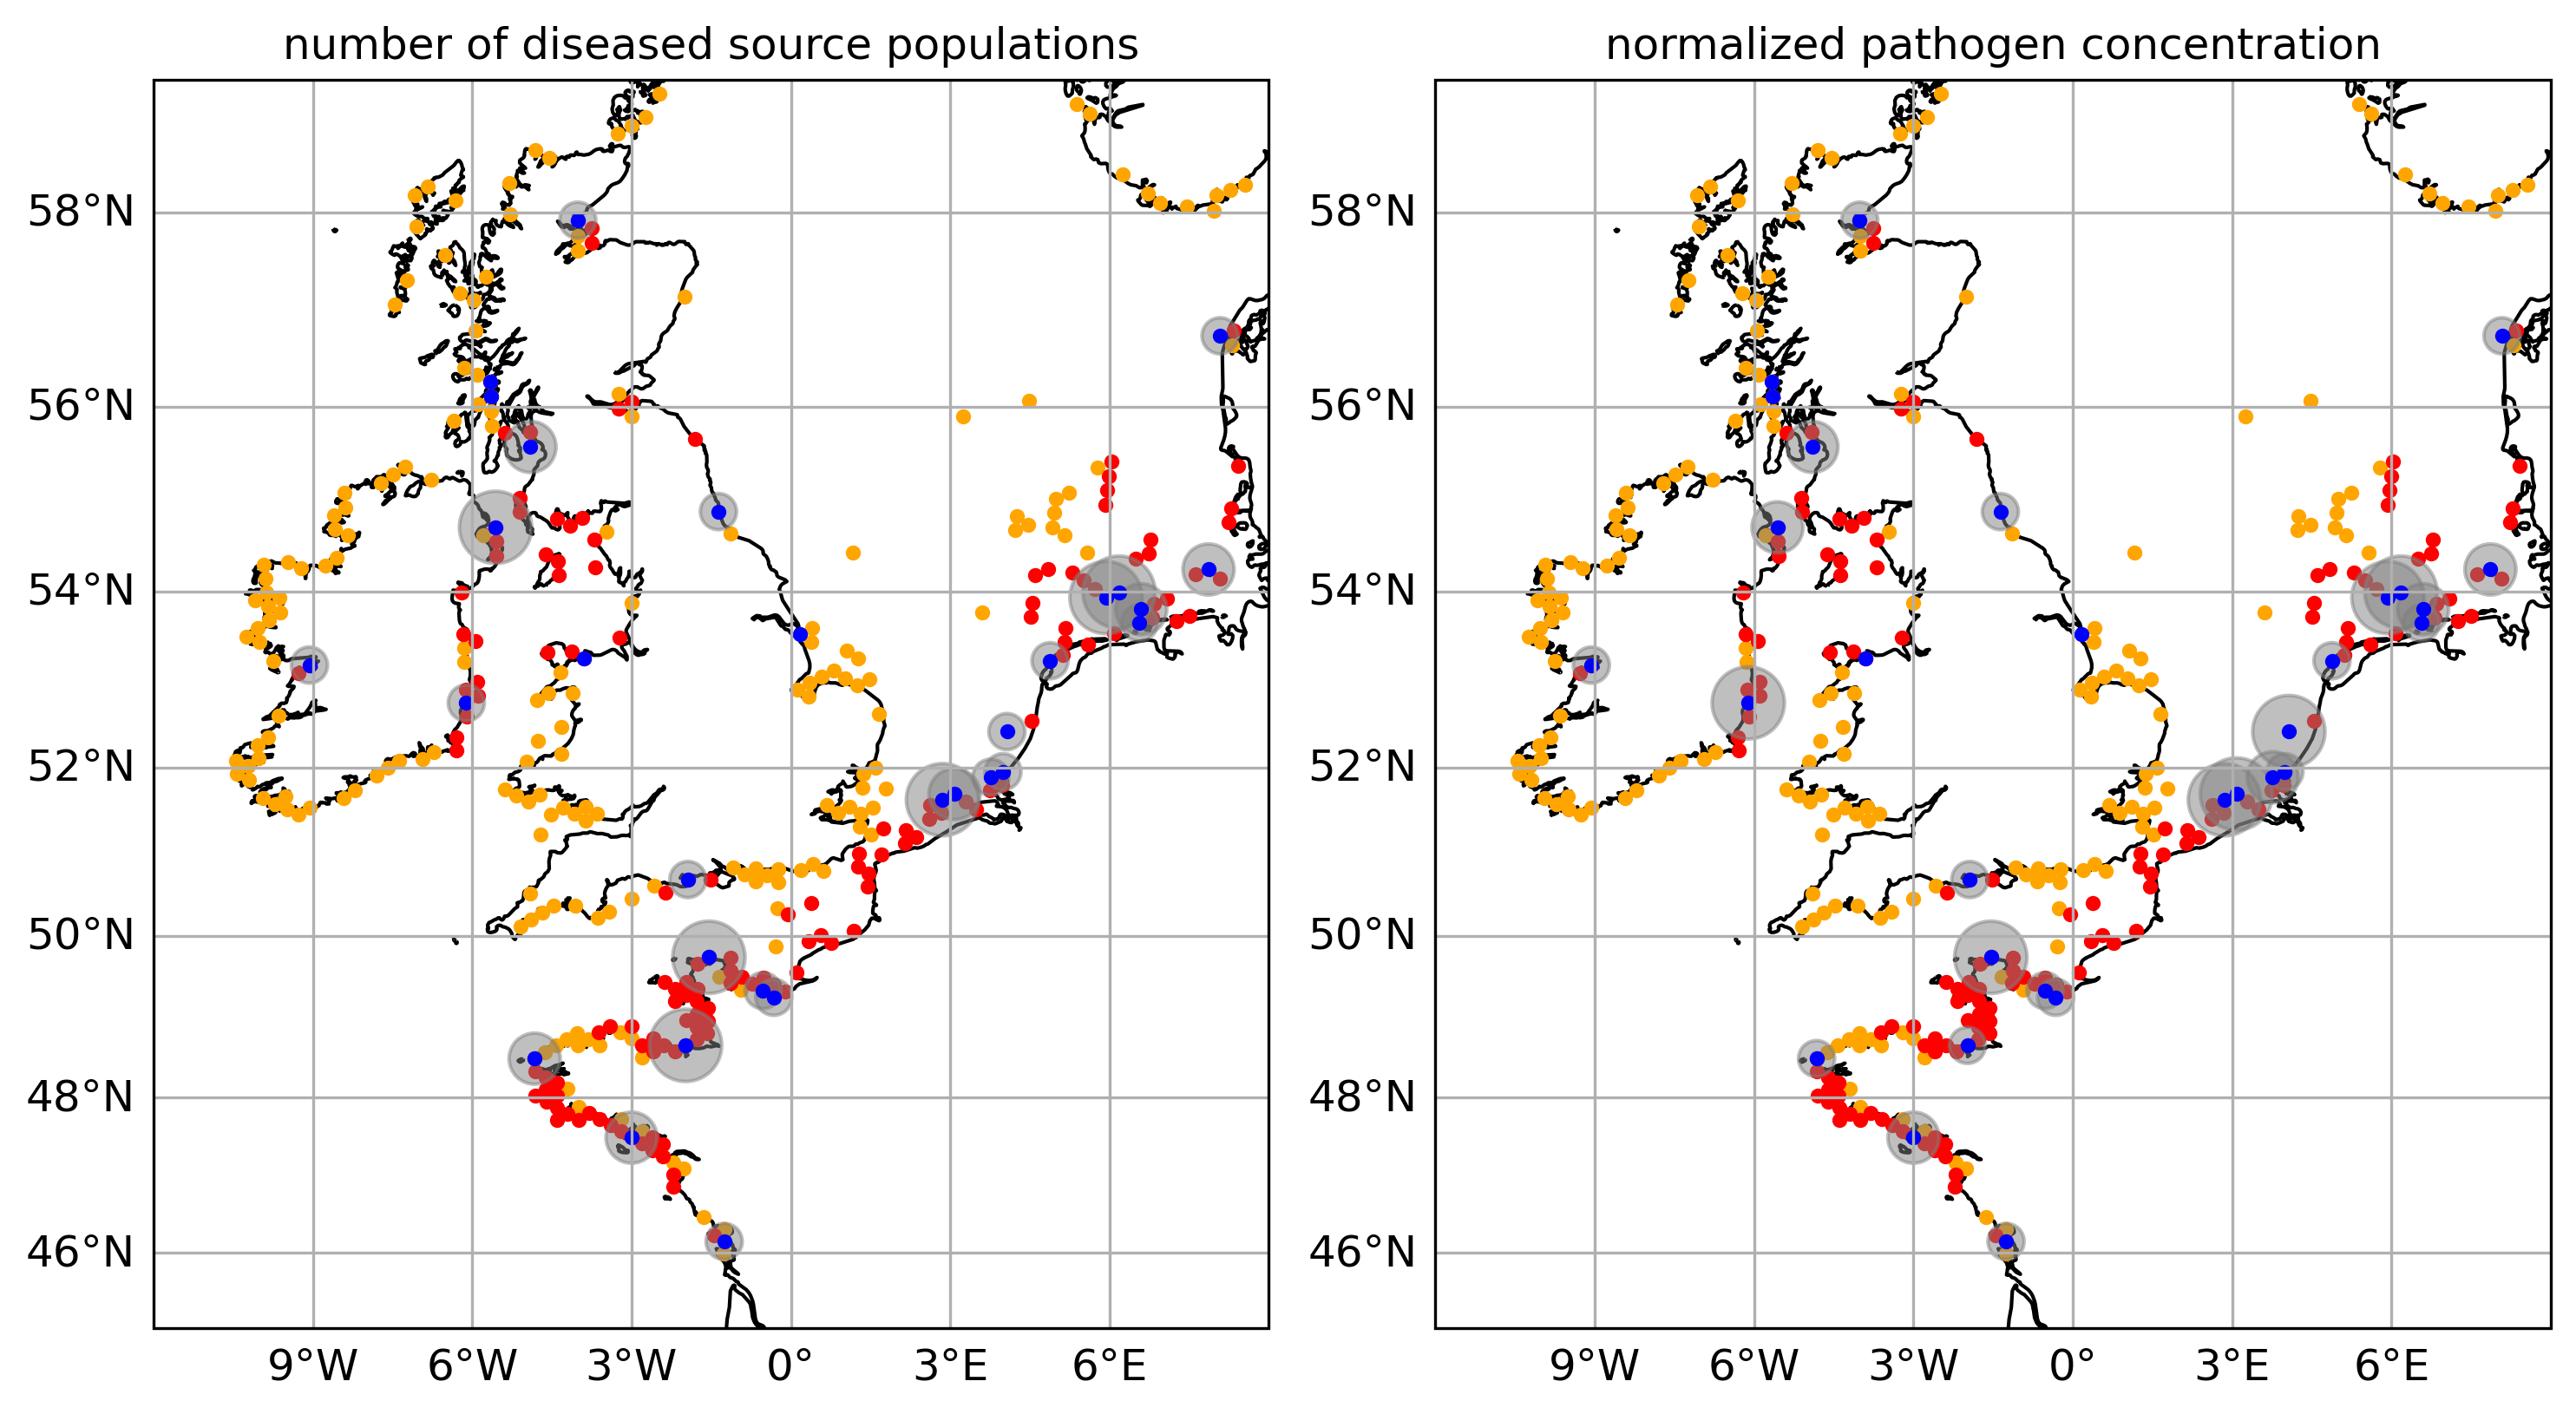

In [18]:
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

fig.patch.set_alpha(0.7)

_dssaqchis_to_rst_stats = dssaqchis_to_rst_stats.copy()

_dssaqchis_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dssaqchis_to_rst_stats["rel_pathogen_concentration_category"] *= 100

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

_dssaqchis_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_num_dss_sources_category",
    alpha=0.5, color="gray",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue",
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

ax[0].coastlines(zorder=0)

ax[0].set_title("number of diseased source populations")
ax[0].set_extent([-12, 9, 45, 59])
gl1 = ax[0].gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

_dssaqchis_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue",
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

ax[1].coastlines(zorder=0)

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 45, 59])
gl2 = ax[1].gridlines(draw_labels=True)
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels;

fig.tight_layout();

fig.savefig("plots/041_rest-sites_risk-analsysis_dssaqchis.pdf")

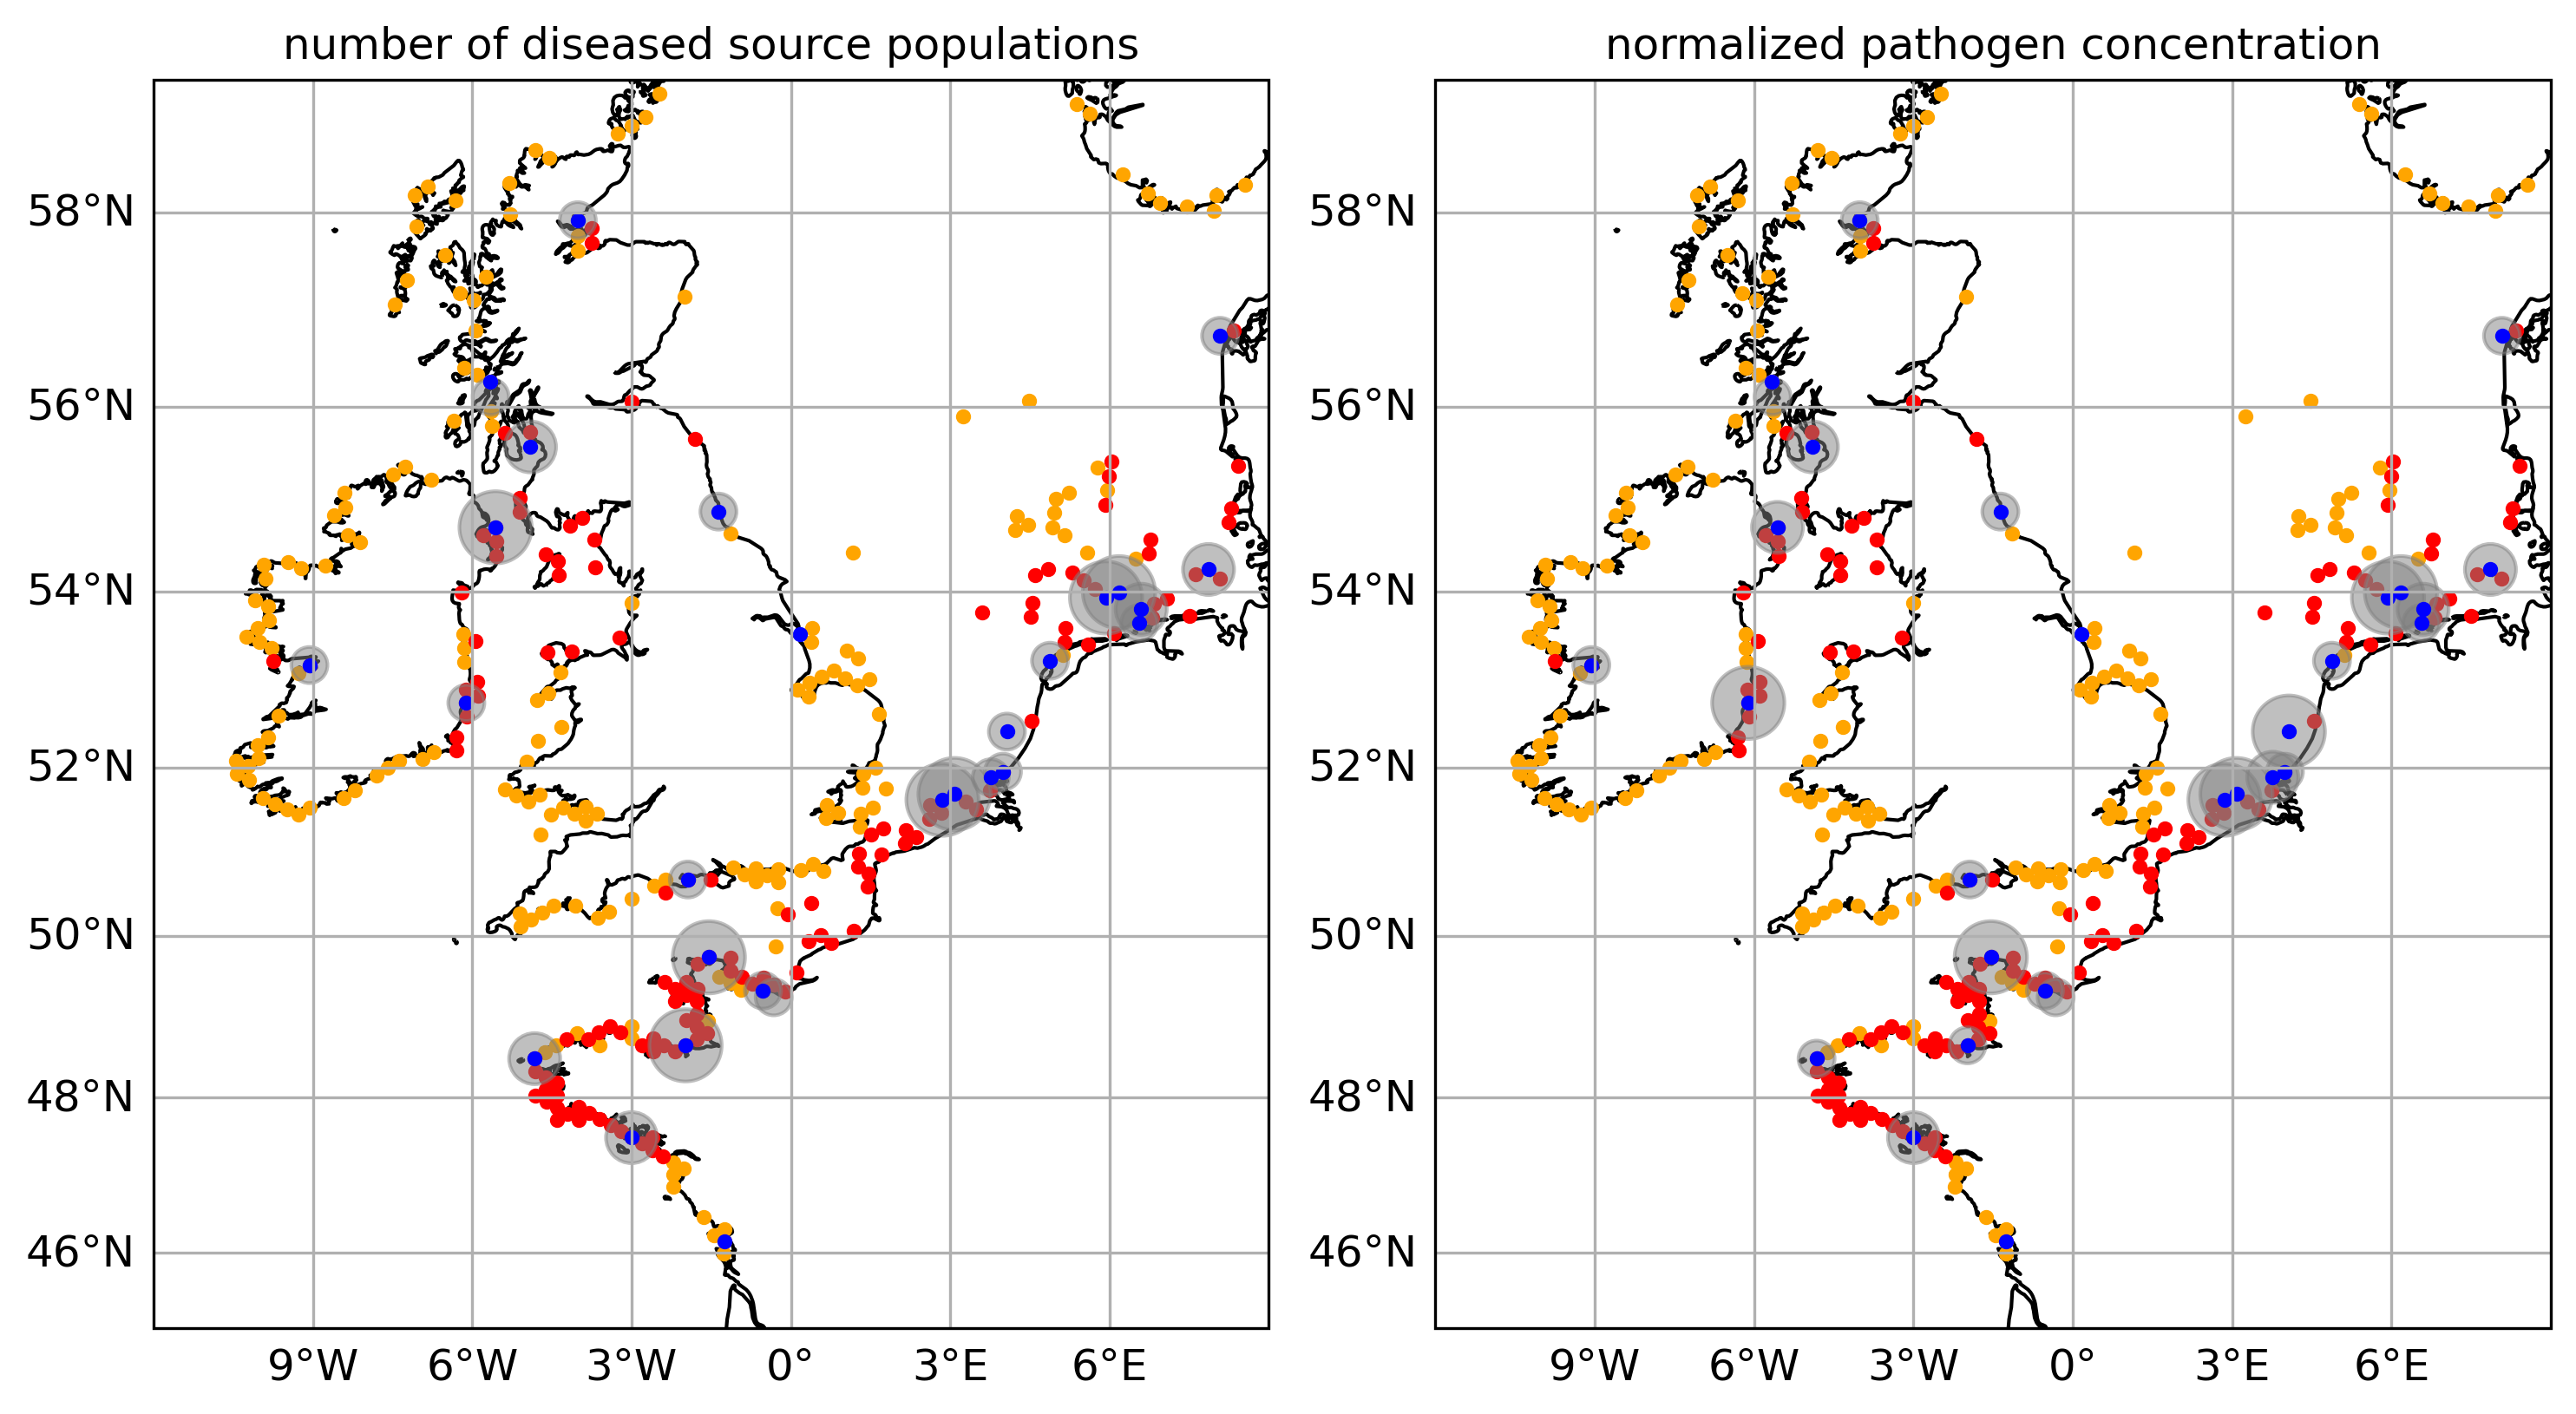

In [30]:
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

fig.patch.set_alpha(0.7)

_dssaqchis_to_rst_stats = dssaqchis_to_rst_stats.copy()

_dssaqchis_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dssaqchis_to_rst_stats["rel_pathogen_concentration_category"] *= 100

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

_dssaqchis_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_num_dss_sources_category",
    alpha=0.5, color="gray",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue",
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

ax[0].coastlines(zorder=0)

ax[0].set_title("number of diseased source populations")
ax[0].set_extent([-12, 9, 45, 59])
gl1 = ax[0].gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

_dssaqchis_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue",
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

ax[1].coastlines(zorder=0)

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 45, 59])
gl2 = ax[1].gridlines(draw_labels=True)
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels;

fig.tight_layout();

fig.savefig("plots/041_rest-sites_risk-analsysis_dssaqchis.pdf")

### Diseased + aquaculture + historical to restoration PER MONTH AND YEAR

In [39]:
dssaqchis_to_rst_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0) | (ds_conn.his_count_hex0 > 0) | (ds_conn.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.rst_count_hex1 > 0)
)

dssaqchis_to_rst_01y

<xarray.DataArray 'obs_per_target_area' (month: 5, year: 4, hex0: 362,
                                         hex1: 8377)>
dask.array<where, shape=(5, 4, 362, 8377), dtype=float64, chunksize=(1, 1, 362, 8377), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -59, 50)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(362,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(8377,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(362,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(8377,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(362,), meta=np.ndarray>

In [40]:
year_name_mapping = {
    0: '2019',
    1: '2020',
    2: '2021',
    3: '2022',
}

month_name_mapping = {
    0: 'May',
    1: 'June',
    2: 'July',
    3: 'August',
    4: 'September',
}

# Apply the mappings to the xarray dataset
dssaqchis_to_rst_01y['year'] = [year_name_mapping.get(y, y) for y in dssaqchis_to_rst_01y['year'].values]
dssaqchis_to_rst_01y['month'] = [month_name_mapping.get(m, m) for m in dssaqchis_to_rst_01y['month'].values]

# Print the updated xarray dataset
dssaqchis_to_rst_01y

<xarray.DataArray 'obs_per_target_area' (month: 5, year: 4, hex0: 362,
                                         hex1: 8377)>
dask.array<where, shape=(5, 4, 362, 8377), dtype=float64, chunksize=(1, 1, 362, 8377), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -59, 50)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) <U9 'May' 'June' 'July' 'August' 'September'
  * year       (year) <U4 '2019' '2020' '2021' '2022'
    lon_hex0   (hex0) float64 dask.array<chunksize=(362,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(8377,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(362,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(8377,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(362,), meta=np.ndarray>

In [41]:
known_rst_sites = ds_conn.rst_count_hex0.where(ds_conn.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()
known_rst_sites

lon_hex0   lat_hex0       hex_label  rst_count_hex0
hex0                                                               
(-11, 16, -5)  -5.652154  56.105601   (-11, 16, -5)             1.0
(-11, 17, -6)  -5.662842  56.261053   (-11, 17, -6)             1.0
(-11, 7, 4)    -5.560333  54.706424     (-11, 7, 4)             1.0
(-14, -4, 18)  -6.110616  52.746676   (-14, -4, 18)             1.0
(-27, 6, 21)   -9.065311  53.176870    (-27, 6, 21)             1.0
(-4, 24, -20)  -4.011904  57.918896   (-4, 24, -20)             1.0
(-8, 11, -3)   -4.902596  55.574491    (-8, 11, -3)             1.0
(-9, -34, 43)  -4.824256  48.488479   (-9, -34, 43)             2.0
(0, -45, 45)   -3.000000  47.489861    (0, -45, 45)             1.0
(12, -39, 27)  -0.525187  49.333480   (12, -39, 27)             1.0
(13, -40, 27)  -0.323419  49.250746   (13, -40, 27)             1.0
(14, -13, -1)   0.167534  53.524029   (14, -13, -1)             1.0
(27, -31, 4)    2.854403  51.626277    (27, -31, 4)             2.0
(28, -31, 3)    3.080785  51.692529    (28, -31, 3)             1.0
(31, -31, 0)    3.764009  51.888537    (31, -31, 0)             1.0
(32, -28, -4)   4.067194  52.417435   (32, -28, -4)             1.0
(32, -31, -1)   3.993107  51.952949   (32, -31, -1)             1.0
(35, -24, -11)  4.878878  53.225639  (35, -24, -11)             1.0
(39, -21, -18)  5.933679  53.933641  (39, -21, -18)             1.0
(40, -21, -19)  6.177440  53.993490  (40, -21, -19)             1.0
(42, -23, -19)  6.595486  53.803701  (42, -23, -19)             1.0
(42, -24, -18)  6.560140  53.649690  (42, -24, -18)             1.0
(45, -5, -40)   8.080625  56.741595   (45, -5, -40)             1.0
(47, -22, -25)  7.862873  54.244597  (47, -22, -25)             1.0
(5, -27, 22)   -1.939319  50.680946    (5, -27, 22)             1.0
(5, -40, 35)   -1.983200  48.655073    (5, -40, 35)             1.0
(7, -1, -6)    -1.364036  54.877988     (7, -1, -6)             1.0
(7, -34, 27)   -1.544287  49.741493    (7, -34, 27)             1.0
(9, -58, 49)   -1.256751  46.148070    (9, -58, 49)             1.0

In [42]:
dssaqchis_origins_01y = dssaqchis_to_rst_01y.sum(["hex1"]).compute().to_dataframe().reset_index(level=['year', 'month','hex0'])
dssaqchis_origins_01y.where(dssaqchis_origins_01y["obs_per_origin_area"] > 0).dropna()

month  year           hex0  lon_hex0   lat_hex0      hex_label  \
1           May  2019  (-1, -44, 45) -3.199006  47.567702  (-1, -44, 45)   
8           May  2019  (-10, 13, -3) -5.387340  55.721769  (-10, 13, -3)   
17          May  2019    (-11, 7, 4) -5.560333  54.706424    (-11, 7, 4)   
24          May  2019  (-13, -3, 16) -5.904284  52.985637  (-13, -3, 16)   
25          May  2019  (-13, -4, 17) -5.893848  52.830131  (-13, -4, 17)   
...         ...   ...            ...       ...        ...            ...   
6854  September  2021   (6, -39, 33) -1.774072  48.886829   (6, -39, 33)   
6855  September  2021   (6, -40, 34) -1.777946  48.730928   (6, -40, 34)   
6860  September  2021   (7, -34, 27) -1.544287  49.741493   (7, -34, 27)   
6863  September  2021   (7, -40, 33) -1.572059  48.806387   (7, -40, 33)   
6872  September  2021   (9, -35, 26) -1.128520  49.735222   (9, -35, 26)   

      obs_per_target_area  
1               49.833333  
8              222.000000  
17              49.840000  
24            4473.250000  
25            7286.250000  
...                   ...  
6854            41.785714  
6855            39.000000  
6860           366.394737  
6863            22.285714  
6872            60.552632  

[1170 rows x 7 columns]

In [43]:
dssaqchis_origin_count_01y = (dssaqchis_to_rst_01y > 0).sum("hex0").compute().to_dataframe().reset_index(level=['year', 'month','hex1']) #origins per hex1
dssaqchis_origin_count_01y

month  year           hex1  lon_hex1   lat_hex1  \
0             May  2019  (-1, -19, 20) -3.215782  51.464504   
1             May  2019    (-1, -2, 3) -3.229353  54.110720   
2             May  2019  (-1, -20, 21) -3.215043  51.308774   
3             May  2019  (-1, -21, 22) -3.214311  51.153035   
4             May  2019  (-1, -24, 25) -3.212150  50.685757   
...           ...   ...            ...       ...        ...   
167535  September  2022    (9, 5, -14) -0.838398  55.959362   
167536  September  2022    (9, 6, -15) -0.829731  56.114857   
167537  September  2022    (9, 7, -16) -0.820982  56.270351   
167538  September  2022    (9, 8, -17) -0.812150  56.425843   
167539  September  2022    (9, 9, -18) -0.803232  56.581335   

        obs_per_target_area  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
167535                    0  
167536                    0  
167537                    0  
167538                    0  
167539                    0  

[167540 rows x 6 columns]

In [44]:
dssaqchis_destinations_01y = dssaqchis_to_rst_01y.sum(["hex0"]).compute().to_dataframe().reset_index(level=['year', 'month','hex1'])
dssaqchis_destinations_01y

month  year           hex1  lon_hex1   lat_hex1  \
0             May  2019  (-1, -19, 20) -3.215782  51.464504   
1             May  2019    (-1, -2, 3) -3.229353  54.110720   
2             May  2019  (-1, -20, 21) -3.215043  51.308774   
3             May  2019  (-1, -21, 22) -3.214311  51.153035   
4             May  2019  (-1, -24, 25) -3.212150  50.685757   
...           ...   ...            ...       ...        ...   
167535  September  2022    (9, 5, -14) -0.838398  55.959362   
167536  September  2022    (9, 6, -15) -0.829731  56.114857   
167537  September  2022    (9, 7, -16) -0.820982  56.270351   
167538  September  2022    (9, 8, -17) -0.812150  56.425843   
167539  September  2022    (9, 9, -18) -0.803232  56.581335   

        obs_per_target_area  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
167535                  0.0  
167536                  0.0  
167537                  0.0  
167538                  0.0  
167539                  0.0  

[167540 rows x 6 columns]

In [45]:
dssaqchis_to_rst_stats = (
    dssaqchis_origin_count_01y
    .where(dssaqchis_origin_count_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"lon_hex1": "lon", "lat_hex1": "lat", "obs_per_origin_area": "num_dss_sources"})
)

dssaqchis_to_rst_stats = dssaqchis_to_rst_stats.join(
    dssaqchis_destinations_01y
    .where(dssaqchis_destinations_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"obs_per_origin_area": "rel_pathogen_concentration"})
    [["rel_pathogen_concentration"]]
)

dssaqchis_to_rst_stats

month  year            hex1       lon        lat  num_dss_sources  \
15354      May  2020    (27, -31, 4)  2.854403  51.626277             18.0   
117087  August  2020    (7, -34, 27) -1.544287  49.741493             16.0   
73993     July  2019    (27, -31, 4)  2.854403  51.626277             16.0   
75202     July  2019    (7, -34, 27) -1.544287  49.741493             15.0   
107501  August  2019    (27, -31, 4)  2.854403  51.626277             15.0   
...        ...   ...             ...       ...        ...              ...   
125093  August  2021  (42, -24, -18)  6.560140  53.649690              1.0   
22530      May  2021   (12, -39, 27) -0.525187  49.333480              1.0   
99527     July  2022   (32, -28, -4)  4.067194  52.417435              1.0   
124802  August  2021  (35, -24, -11)  4.878878  53.225639              1.0   
32946      May  2022  (42, -24, -18)  6.560140  53.649690              1.0   

        rel_pathogen_concentration  
15354                 45421.000000  
117087                 4398.789474  
73993                 19943.000000  
75202                  5998.815789  
107501                41480.000000  
...                            ...  
125093                   62.487805  
22530                    16.200000  
99527                    10.000000  
124802                   75.957447  
32946                   158.780488  

[352 rows x 7 columns]

In [46]:
dssaqchis_to_rst_stats["rel_pathogen_concentration"] /= (
    dssaqchis_to_rst_stats.groupby(['year', 'month'])["rel_pathogen_concentration"]
    .transform('max')
)
dssaqchis_to_rst_stats

month  year            hex1       lon        lat  num_dss_sources  \
15354      May  2020    (27, -31, 4)  2.854403  51.626277             18.0   
117087  August  2020    (7, -34, 27) -1.544287  49.741493             16.0   
73993     July  2019    (27, -31, 4)  2.854403  51.626277             16.0   
75202     July  2019    (7, -34, 27) -1.544287  49.741493             15.0   
107501  August  2019    (27, -31, 4)  2.854403  51.626277             15.0   
...        ...   ...             ...       ...        ...              ...   
125093  August  2021  (42, -24, -18)  6.560140  53.649690              1.0   
22530      May  2021   (12, -39, 27) -0.525187  49.333480              1.0   
99527     July  2022   (32, -28, -4)  4.067194  52.417435              1.0   
124802  August  2021  (35, -24, -11)  4.878878  53.225639              1.0   
32946      May  2022  (42, -24, -18)  6.560140  53.649690              1.0   

        rel_pathogen_concentration  
15354                     1.000000  
117087                    0.132112  
73993                     0.806756  
75202                     0.242671  
107501                    1.000000  
...                            ...  
125093                    0.002174  
22530                     0.000314  
99527                     0.000469  
124802                    0.002643  
32946                     0.003697  

[352 rows x 7 columns]

In [47]:
dssaqchis_to_rst_stats["rel_num_dss_sources"] = dssaqchis_to_rst_stats["num_dss_sources"] / (
    dssaqchis_to_rst_stats.groupby(['year', 'month'])["num_dss_sources"]
    .transform('max')
)
dssaqchis_to_rst_stats

month  year            hex1       lon        lat  num_dss_sources  \
15354      May  2020    (27, -31, 4)  2.854403  51.626277             18.0   
117087  August  2020    (7, -34, 27) -1.544287  49.741493             16.0   
73993     July  2019    (27, -31, 4)  2.854403  51.626277             16.0   
75202     July  2019    (7, -34, 27) -1.544287  49.741493             15.0   
107501  August  2019    (27, -31, 4)  2.854403  51.626277             15.0   
...        ...   ...             ...       ...        ...              ...   
125093  August  2021  (42, -24, -18)  6.560140  53.649690              1.0   
22530      May  2021   (12, -39, 27) -0.525187  49.333480              1.0   
99527     July  2022   (32, -28, -4)  4.067194  52.417435              1.0   
124802  August  2021  (35, -24, -11)  4.878878  53.225639              1.0   
32946      May  2022  (42, -24, -18)  6.560140  53.649690              1.0   

        rel_pathogen_concentration  rel_num_dss_sources  
15354                     1.000000             1.000000  
117087                    0.132112             1.000000  
73993                     0.806756             1.000000  
75202                     0.242671             0.937500  
107501                    1.000000             1.000000  
...                            ...                  ...  
125093                    0.002174             0.083333  
22530                     0.000314             0.090909  
99527                     0.000469             0.111111  
124802                    0.002643             0.083333  
32946                     0.003697             0.100000  

[352 rows x 8 columns]

In [48]:
dssaqchis_to_rst_stats.where(dssaqchis_to_rst_stats.rel_pathogen_concentration > 0).dropna()

month  year            hex1       lon        lat  num_dss_sources  \
15354      May  2020    (27, -31, 4)  2.854403  51.626277             18.0   
117087  August  2020    (7, -34, 27) -1.544287  49.741493             16.0   
73993     July  2019    (27, -31, 4)  2.854403  51.626277             16.0   
75202     July  2019    (7, -34, 27) -1.544287  49.741493             15.0   
107501  August  2019    (27, -31, 4)  2.854403  51.626277             15.0   
...        ...   ...             ...       ...        ...              ...   
125093  August  2021  (42, -24, -18)  6.560140  53.649690              1.0   
22530      May  2021   (12, -39, 27) -0.525187  49.333480              1.0   
99527     July  2022   (32, -28, -4)  4.067194  52.417435              1.0   
124802  August  2021  (35, -24, -11)  4.878878  53.225639              1.0   
32946      May  2022  (42, -24, -18)  6.560140  53.649690              1.0   

        rel_pathogen_concentration  rel_num_dss_sources  
15354                     1.000000             1.000000  
117087                    0.132112             1.000000  
73993                     0.806756             1.000000  
75202                     0.242671             0.937500  
107501                    1.000000             1.000000  
...                            ...                  ...  
125093                    0.002174             0.083333  
22530                     0.000314             0.090909  
99527                     0.000469             0.111111  
124802                    0.002643             0.083333  
32946                     0.003697             0.100000  

[352 rows x 8 columns]

In [49]:
dssaqchis_to_rst_stats.num_dss_sources.unique()

array([18., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,
        4.,  3.,  2.,  1.])

In [50]:
dssaqchis_to_rst_stats["rel_num_dss_sources_category"] = pd.qcut(
    dssaqchis_to_rst_stats.rel_num_dss_sources,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)
dssaqchis_to_rst_stats["rel_pathogen_concentration_category"] = pd.qcut(
    dssaqchis_to_rst_stats.rel_pathogen_concentration,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)

dssaqchis_to_rst_stats

month  year            hex1       lon        lat  num_dss_sources  \
15354      May  2020    (27, -31, 4)  2.854403  51.626277             18.0   
117087  August  2020    (7, -34, 27) -1.544287  49.741493             16.0   
73993     July  2019    (27, -31, 4)  2.854403  51.626277             16.0   
75202     July  2019    (7, -34, 27) -1.544287  49.741493             15.0   
107501  August  2019    (27, -31, 4)  2.854403  51.626277             15.0   
...        ...   ...             ...       ...        ...              ...   
125093  August  2021  (42, -24, -18)  6.560140  53.649690              1.0   
22530      May  2021   (12, -39, 27) -0.525187  49.333480              1.0   
99527     July  2022   (32, -28, -4)  4.067194  52.417435              1.0   
124802  August  2021  (35, -24, -11)  4.878878  53.225639              1.0   
32946      May  2022  (42, -24, -18)  6.560140  53.649690              1.0   

        rel_pathogen_concentration  rel_num_dss_sources  \
15354                     1.000000             1.000000   
117087                    0.132112             1.000000   
73993                     0.806756             1.000000   
75202                     0.242671             0.937500   
107501                    1.000000             1.000000   
...                            ...                  ...   
125093                    0.002174             0.083333   
22530                     0.000314             0.090909   
99527                     0.000469             0.111111   
124802                    0.002643             0.083333   
32946                     0.003697             0.100000   

        rel_num_dss_sources_category  rel_pathogen_concentration_category  
15354                            4.0                                  4.0  
117087                           4.0                                  2.0  
73993                            4.0                                  4.0  
75202                            4.0                                  2.0  
107501                           4.0                                  4.0  
...                              ...                                  ...  
125093                           1.0                                  1.0  
22530                            1.0                                  1.0  
99527                            1.0                                  1.0  
124802                           1.0                                  1.0  
32946                            1.0                                  1.0  

[352 rows x 10 columns]

In [51]:
dssaqchis_to_rst_stats_reset = dssaqchis_to_rst_stats.reset_index()
dssaqchis_to_rst_stats_reset

index   month  year            hex1       lon        lat  \
0     15354     May  2020    (27, -31, 4)  2.854403  51.626277   
1    117087  August  2020    (7, -34, 27) -1.544287  49.741493   
2     73993    July  2019    (27, -31, 4)  2.854403  51.626277   
3     75202    July  2019    (7, -34, 27) -1.544287  49.741493   
4    107501  August  2019    (27, -31, 4)  2.854403  51.626277   
..      ...     ...   ...             ...       ...        ...   
347  125093  August  2021  (42, -24, -18)  6.560140  53.649690   
348   22530     May  2021   (12, -39, 27) -0.525187  49.333480   
349   99527    July  2022   (32, -28, -4)  4.067194  52.417435   
350  124802  August  2021  (35, -24, -11)  4.878878  53.225639   
351   32946     May  2022  (42, -24, -18)  6.560140  53.649690   

     num_dss_sources  rel_pathogen_concentration  rel_num_dss_sources  \
0               18.0                    1.000000             1.000000   
1               16.0                    0.132112             1.000000   
2               16.0                    0.806756             1.000000   
3               15.0                    0.242671             0.937500   
4               15.0                    1.000000             1.000000   
..               ...                         ...                  ...   
347              1.0                    0.002174             0.083333   
348              1.0                    0.000314             0.090909   
349              1.0                    0.000469             0.111111   
350              1.0                    0.002643             0.083333   
351              1.0                    0.003697             0.100000   

     rel_num_dss_sources_category  rel_pathogen_concentration_category  
0                             4.0                                  4.0  
1                             4.0                                  2.0  
2                             4.0                                  4.0  
3                             4.0                                  2.0  
4                             4.0                                  4.0  
..                            ...                                  ...  
347                           1.0                                  1.0  
348                           1.0                                  1.0  
349                           1.0                                  1.0  
350                           1.0                                  1.0  
351                           1.0                                  1.0  

[352 rows x 11 columns]

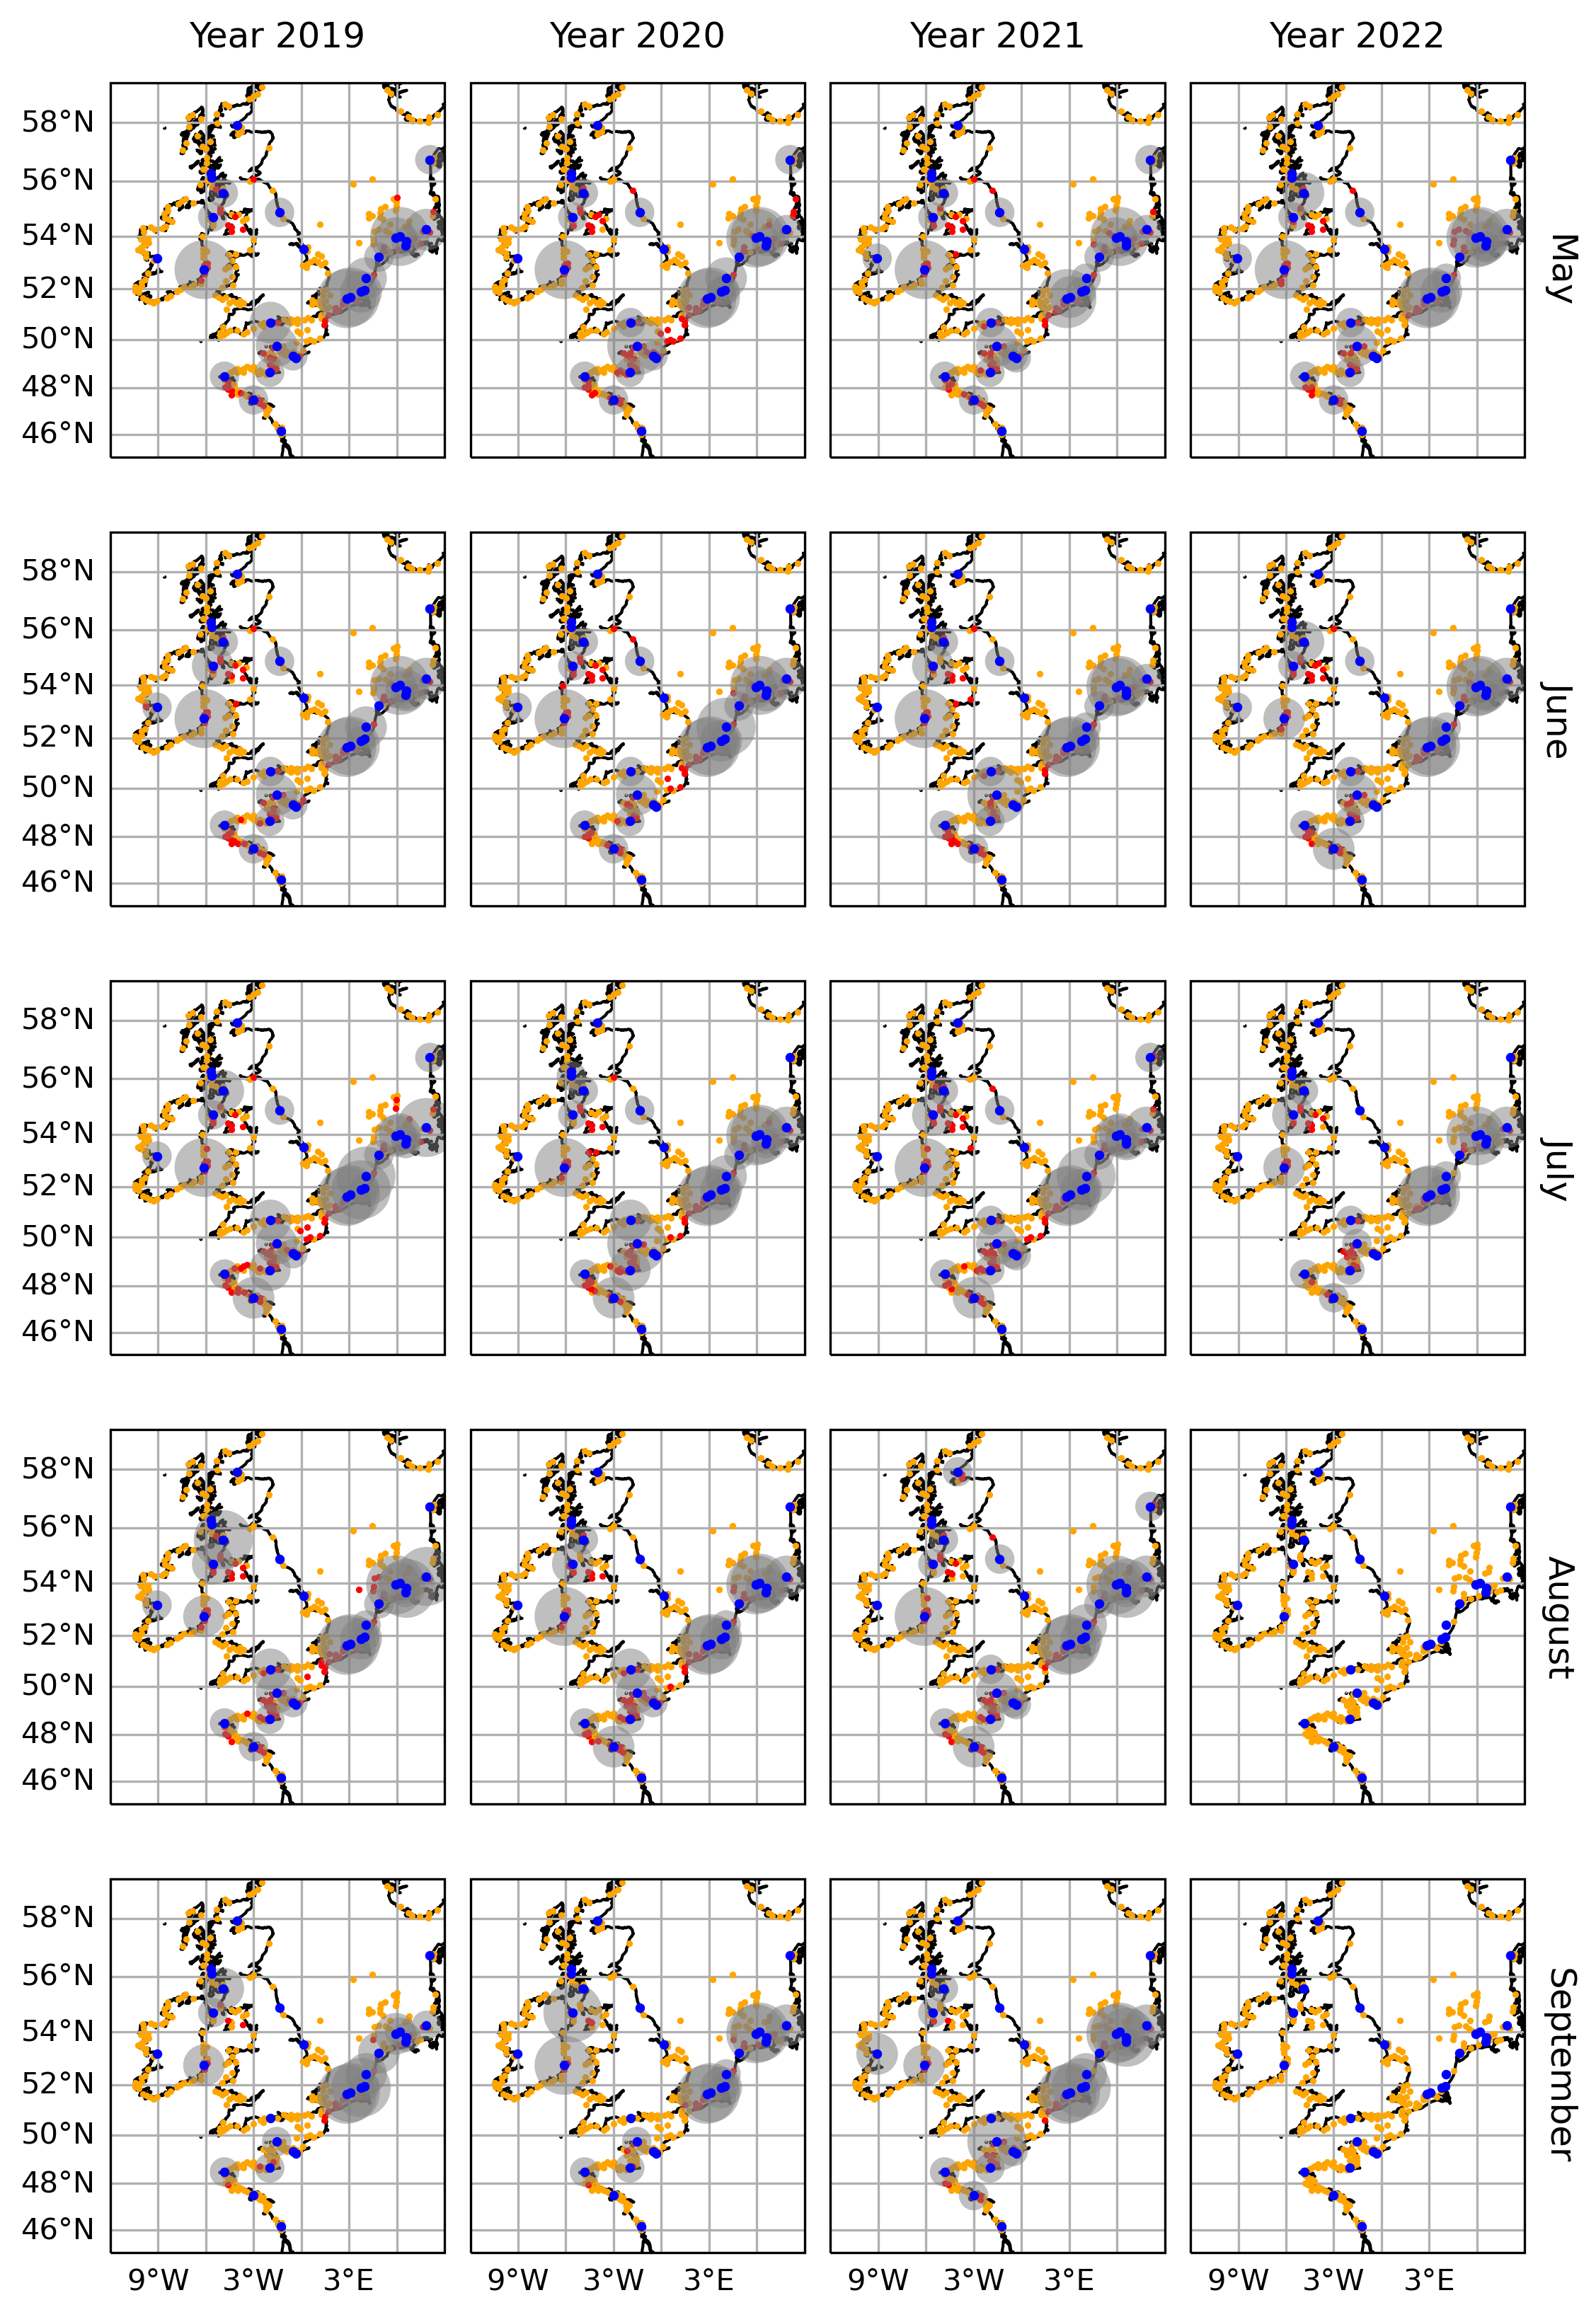

In [70]:
years = ['2019','2020','2021','2022']
months = ['May','June','July','August','September']
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.Mercator()}, 
                         figsize=(10, 14))

fig.set_dpi(300)

fig.patch.set_alpha(0.7)

#loop to make plots for each year and month
for i, year in enumerate(years):
    for j, month in enumerate(months):
        ax = axes [j,i]
        
        ax.coastlines(zorder=0)

        #subset to only plot relative risk for each month&year
        subset = dssaqchis_to_rst_stats_reset[(dssaqchis_to_rst_stats_reset['year'] == year) & (dssaqchis_to_rst_stats_reset['month'] == month)].copy()
        
        subset["rel_pathogen_concentration_category"] *= 100
        
        
        #subset to only plot relevant sources for each month&year
        origin_subset = dssaqchis_origins_01y[(dssaqchis_origins_01y['year'] == year) & (dssaqchis_origins_01y['month'] == month)].copy()

        origin_subset.where(origin_subset["obs_per_origin_area"] == 0).plot.scatter(
            x="lon_hex0", y="lat_hex0", s=1.5, color="orange",
            ax=ax, transform=cartopy.crs.PlateCarree(),
        )

        origin_subset.where(origin_subset["obs_per_origin_area"] > 0).plot.scatter(
            x="lon_hex0", y="lat_hex0", s=1.5, color="red", 
            ax=ax, transform=cartopy.crs.PlateCarree(),
        )

        subset.plot.scatter(
            x="lon", y="lat", s="rel_pathogen_concentration_category",
            alpha=0.5, color="gray", edgecolor='none', 
            ax=ax, transform=cartopy.crs.PlateCarree(),
        )
        
        #add restoration site locations
        known_rst_sites.plot.scatter(
            x="lon_hex0", y="lat_hex0", s=5, 
            color="blue", 
            ax=ax, transform=cartopy.crs.PlateCarree()
        )
        
        #add axes and labels
        ax.set_extent([-12, 9, 45, 59])
        gl = ax.gridlines(draw_labels=False, zorder=0)
        
        if j == num_months - 1 and month == 'September':
            gl.bottom_labels=True
            gl.top_labels=False
            gl.right_labels=False
        else:
            gl.bottom_labels=False
            gl.top_labels=False
            gl.right_labels=False
            
        # Add y-axis labels only to the leftmost column for 2019
        if i == 0 and year == '2019':
            gl.top_labels=False
            gl.right_labels=False
            gl.left_labels=True
        else:
            gl.top_labels=False
            gl.right_labels=False
            gl.left_labels=False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02) # Adjust the subplot layout
        
#add year and month labels
for i, year in enumerate(years):
    axes[0, i].set_title(f'Year {int(year)}', pad=12, size = 12)
    
for j, month in enumerate(months):
    axes[j, -1].annotate(f'{month}', xy=(1.05, 0.5), xycoords='axes fraction', rotation=270, fontsize=12, ha='left', va='center')
    
#fig.tight_layout();

#save
fig.savefig("plots/041_rest-sites_risk-analsysis_dssaqchis_permonth.pdf")

### Diseased to Restoration AVERAGE

In [19]:
dss_to_rst_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.rst_count_hex1 > 0)
)

dss_to_rst_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 69, hex1: 8402)> Size: 93MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * hex0       (hex0) <U47 13kB '(-1, -36, 37)' ... '(9, -28, 19)'
  * hex1       (hex1) <U47 2MB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 552B -3.204 -3.2 -3.199 ... -1.762 -1.778 -1.085
    lon_hex1   (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex0   (hex0) float64 552B 48.82 47.72 47.57 51.68 ... 49.35 48.73 50.83
    lat_hex1   (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 4kB '(-1, -36, 37)' ... '(9, -28, 19)'

In [20]:
known_rst_sites = ds_conn.rst_count_hex0.where(ds_conn.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()
known_rst_sites

lon_hex0   lat_hex0       hex_label  rst_count_hex0
hex0                                                               
(-11, 16, -5)  -5.652154  56.105601   (-11, 16, -5)             1.0
(-11, 17, -6)  -5.662842  56.261053   (-11, 17, -6)             1.0
(-11, 7, 4)    -5.560333  54.706424     (-11, 7, 4)             1.0
(-14, -4, 18)  -6.110616  52.746676   (-14, -4, 18)             1.0
(-27, 6, 21)   -9.065311  53.176870    (-27, 6, 21)             1.0
(-4, -6, 10)   -3.898922  53.251590    (-4, -6, 10)             1.0
(-4, 24, -20)  -4.011904  57.918896   (-4, 24, -20)             1.0
(-8, 11, -3)   -4.902596  55.574491    (-8, 11, -3)             1.0
(-9, -34, 43)  -4.824256  48.488479   (-9, -34, 43)             2.0
(0, -45, 45)   -3.000000  47.489861    (0, -45, 45)             1.0
(12, -39, 27)  -0.525187  49.333480   (12, -39, 27)             1.0
(13, -40, 27)  -0.323419  49.250746   (13, -40, 27)             1.0
(14, -13, -1)   0.167534  53.524029   (14, -13, -1)             1.0
(27, -31, 4)    2.854403  51.626277    (27, -31, 4)             2.0
(28, -31, 3)    3.080785  51.692529    (28, -31, 3)             1.0
(31, -31, 0)    3.764009  51.888537    (31, -31, 0)             1.0
(32, -28, -4)   4.067194  52.417435   (32, -28, -4)             1.0
(32, -31, -1)   3.993107  51.952949   (32, -31, -1)             1.0
(35, -24, -11)  4.878878  53.225639  (35, -24, -11)             1.0
(39, -21, -18)  5.933679  53.933641  (39, -21, -18)             1.0
(40, -21, -19)  6.177440  53.993490  (40, -21, -19)             1.0
(42, -23, -19)  6.595486  53.803701  (42, -23, -19)             1.0
(42, -24, -18)  6.560140  53.649690  (42, -24, -18)             1.0
(45, -5, -40)   8.080625  56.741595   (45, -5, -40)             1.0
(47, -22, -25)  7.862873  54.244597  (47, -22, -25)             1.0
(5, -27, 22)   -1.939319  50.680946    (5, -27, 22)             1.0
(5, -40, 35)   -1.983200  48.655073    (5, -40, 35)             1.0
(7, -1, -6)    -1.364036  54.877988     (7, -1, -6)             1.0
(7, -34, 27)   -1.544287  49.741493    (7, -34, 27)             1.0
(9, -58, 49)   -1.256751  46.148070    (9, -58, 49)             1.0

In [21]:
dss_origins_01y = dss_to_rst_01y.sum(["month", "year", "hex1"]).compute().to_dataset().to_pandas()
dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).dropna()

lon_hex0   lat_hex0      hex_label  obs_per_origin_area
hex0                                                                  
(-1, -44, 45) -3.199006  47.567702  (-1, -44, 45)           200.074074
(-11, 5, 6)   -5.540939  54.395456    (-11, 5, 6)          2017.026316
(-2, -35, 37) -3.408674  48.892978  (-2, -35, 37)           365.878378
(-2, -43, 45) -3.398617  47.645165  (-2, -43, 45)           642.870968
(-3, -35, 38) -3.612033  48.814059  (-3, -35, 38)            67.096774
(-3, -42, 45) -3.598835  47.722247  (-3, -42, 45)           295.936508
(-4, -41, 45) -3.799659  47.798947  (-4, -41, 45)           223.055556
(-4, 24, -20) -4.011904  57.918896  (-4, 24, -20)            45.955556
(-5, -5, 10)  -4.125671  53.327472   (-5, -5, 10)           158.421053
(-6, -40, 46) -4.199435  47.795198  (-6, -40, 46)           141.565217
(-7, -37, 44) -4.410144  48.182695  (-7, -37, 44)           197.689655
(-7, -38, 45) -4.405781  48.026734  (-7, -38, 45)           355.200000
(-7, -39, 46) -4.401451  47.870756  (-7, -39, 46)           603.680000
(-7, -40, 47) -4.397155  47.714762  (-7, -40, 47)           492.000000
(-8, -36, 44) -4.614045  48.257829  (-8, -36, 44)           149.396226
(-8, -37, 45) -4.609039  48.101885  (-8, -37, 45)           543.111111
(-8, -38, 46) -4.604073  47.945926  (-8, -38, 46)          1062.722222
(-9, -34, 43) -4.824256  48.488479  (-9, -34, 43)           231.696429
(-9, -35, 44) -4.818560  48.332570  (-9, -35, 44)            87.272727
(-9, -37, 46) -4.807300  48.020705  (-9, -37, 46)          1277.337662
(0, -36, 36)  -3.000000  48.893746   (0, -36, 36)            37.500000
(0, -45, 45)  -3.000000  47.489861   (0, -45, 45)          3624.833333
(1, -38, 37)  -2.796628  48.659660   (1, -38, 37)            24.568966
(1, -46, 45)  -2.801599  47.411644   (1, -46, 45)          7854.346667
(2, -39, 37)  -2.593899  48.581116   (2, -39, 37)            25.000000
(2, -46, 44)  -2.602597  47.489117   (2, -46, 44)         11690.391304
(2, -47, 45)  -2.603801  47.333052   (2, -47, 45)          6704.985915
(3, -27, 24)  -2.365689  50.528379   (3, -27, 24)            98.873239
(3, -39, 36)  -2.389897  48.658131   (3, -39, 36)           119.069767
(3, -47, 44)  -2.404807  47.410157   (3, -47, 44)           847.000000
(3, -48, 45)  -2.406606  47.254087   (3, -48, 45)          1391.400000
(31, -32, 1)   3.740570  51.733619   (31, -32, 1)         17901.163636
(32, -31, -1)  3.993107  51.952949  (32, -31, -1)         70567.056604
(32, -32, 0)   3.968826  51.798090   (32, -32, 0)            17.357143
(34, -28, -6)  4.532610  52.544488  (34, -28, -6)         33034.235294
(4, -40, 36)  -2.187822  48.578826   (4, -40, 36)            17.307692
(5, -27, 22)  -1.939319  50.680946   (5, -27, 22)         13260.800000
(5, -40, 35)  -1.983200  48.655073   (5, -40, 35)           331.500000
(6, -36, 30)  -1.762264  49.354450   (6, -36, 30)           232.842105
(6, -40, 34)  -1.777946  48.730928   (6, -40, 34)          3776.378378

In [22]:
dss_destinations_01y = dss_to_rst_01y.sum(["month", "year", "hex0"]).compute().to_dataset().to_pandas()
dss_destinations_01y

lon_hex1   lat_hex1  obs_per_origin_area
hex1                                                   
(-1, -19, 20) -3.215782  51.464504                  0.0
(-1, -2, 3)   -3.229353  54.110720                  0.0
(-1, -20, 21) -3.215043  51.308774                  0.0
(-1, -21, 22) -3.214311  51.153035                  0.0
(-1, -24, 25) -3.212150  50.685757                  0.0
...                 ...        ...                  ...
(9, 5, -14)   -0.838398  55.959362                  0.0
(9, 6, -15)   -0.829731  56.114857                  0.0
(9, 7, -16)   -0.820982  56.270351                  0.0
(9, 8, -17)   -0.812150  56.425843                  0.0
(9, 9, -18)   -0.803232  56.581335                  0.0

[8402 rows x 3 columns]

In [23]:
dss_origin_count_01y = (dss_to_rst_01y.sum(["month", "year"]) > 0).sum("hex0").compute().to_dataset().to_pandas()
dss_origin_count_01y

lon_hex1   lat_hex1  obs_per_origin_area
hex1                                                   
(-1, -19, 20) -3.215782  51.464504                    0
(-1, -2, 3)   -3.229353  54.110720                    0
(-1, -20, 21) -3.215043  51.308774                    0
(-1, -21, 22) -3.214311  51.153035                    0
(-1, -24, 25) -3.212150  50.685757                    0
...                 ...        ...                  ...
(9, 5, -14)   -0.838398  55.959362                    0
(9, 6, -15)   -0.829731  56.114857                    0
(9, 7, -16)   -0.820982  56.270351                    0
(9, 8, -17)   -0.812150  56.425843                    0
(9, 9, -18)   -0.803232  56.581335                    0

[8402 rows x 3 columns]

In [24]:
dss_to_rst_stats = (
    dss_origin_count_01y
    .where(dss_origin_count_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"lon_hex1": "lon", "lat_hex1": "lat", "obs_per_origin_area": "num_dss_sources"})
)

dss_to_rst_stats = dss_to_rst_stats.join(
    dss_destinations_01y
    .where(dss_destinations_01y["obs_per_origin_area"] > 0).dropna()
    .sort_values("obs_per_origin_area", ascending=False)
    .rename(columns={"obs_per_origin_area": "rel_pathogen_concentration"})
    [["rel_pathogen_concentration"]]
)

dss_to_rst_stats["rel_pathogen_concentration"] /= dss_to_rst_stats["rel_pathogen_concentration"].max()

dss_to_rst_stats["rel_num_dss_sources"] = dss_to_rst_stats["num_dss_sources"] / dss_to_rst_stats["num_dss_sources"].max()

dss_to_rst_stats.where(dss_to_rst_stats.rel_pathogen_concentration > 0).dropna()

lon        lat  num_dss_sources  \
hex1                                                   
(-9, -34, 43)  -4.824256  48.488479             14.0   
(0, -45, 45)   -3.000000  47.489861             14.0   
(7, -34, 27)   -1.544287  49.741493              6.0   
(5, -40, 35)   -1.983200  48.655073              6.0   
(32, -28, -4)   4.067194  52.417435              4.0   
(28, -31, 3)    3.080785  51.692529              2.0   
(27, -31, 4)    2.854403  51.626277              2.0   
(-11, 7, 4)    -5.560333  54.706424              2.0   
(40, -21, -19)  6.177440  53.993490              2.0   
(39, -21, -18)  5.933679  53.933641              2.0   
(31, -31, 0)    3.764009  51.888537              2.0   
(35, -24, -11)  4.878878  53.225639              2.0   
(5, -27, 22)   -1.939319  50.680946              2.0   
(-8, 11, -3)   -4.902596  55.574491              1.0   
(-4, 24, -20)  -4.011904  57.918896              1.0   
(42, -23, -19)  6.595486  53.803701              1.0   

                rel_pathogen_concentration  rel_num_dss_sources  
hex1                                                             
(-9, -34, 43)                     0.066408             1.000000  
(0, -45, 45)                      0.444412             1.000000  
(7, -34, 27)                      0.010216             0.428571  
(5, -40, 35)                      0.055886             0.428571  
(32, -28, -4)                     1.000000             0.285714  
(28, -31, 3)                      0.099727             0.142857  
(27, -31, 4)                      0.013690             0.142857  
(-11, 7, 4)                       0.014482             0.142857  
(40, -21, -19)                    0.183319             0.142857  
(39, -21, -18)                    0.214512             0.142857  
(31, -31, 0)                      0.088269             0.142857  
(35, -24, -11)                    0.007114             0.142857  
(5, -27, 22)                      0.176722             0.142857  
(-8, 11, -3)                      0.014295             0.071429  
(-4, 24, -20)                     0.000608             0.071429  
(42, -23, -19)                    0.000833             0.071429

In [25]:
import pandas as pd

In [26]:
dss_to_rst_stats.num_dss_sources.unique()

array([14.,  6.,  4.,  2.,  1.])

In [27]:
dss_to_rst_stats["rel_num_dss_sources_category"] = pd.qcut(
    dss_to_rst_stats.rel_num_dss_sources,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)
dss_to_rst_stats["rel_pathogen_concentration_category"] = pd.qcut(
    dss_to_rst_stats.rel_pathogen_concentration,
    q=[0, 1/2, 3/4, 1],
    labels=[1, 2, 4],
).astype(float)

In [28]:
dss_to_rst_stats

lon        lat  num_dss_sources  \
hex1                                                   
(-9, -34, 43)  -4.824256  48.488479             14.0   
(0, -45, 45)   -3.000000  47.489861             14.0   
(7, -34, 27)   -1.544287  49.741493              6.0   
(5, -40, 35)   -1.983200  48.655073              6.0   
(32, -28, -4)   4.067194  52.417435              4.0   
(28, -31, 3)    3.080785  51.692529              2.0   
(27, -31, 4)    2.854403  51.626277              2.0   
(-11, 7, 4)    -5.560333  54.706424              2.0   
(40, -21, -19)  6.177440  53.993490              2.0   
(39, -21, -18)  5.933679  53.933641              2.0   
(31, -31, 0)    3.764009  51.888537              2.0   
(35, -24, -11)  4.878878  53.225639              2.0   
(5, -27, 22)   -1.939319  50.680946              2.0   
(-8, 11, -3)   -4.902596  55.574491              1.0   
(-4, 24, -20)  -4.011904  57.918896              1.0   
(42, -23, -19)  6.595486  53.803701              1.0   

                rel_pathogen_concentration  rel_num_dss_sources  \
hex1                                                              
(-9, -34, 43)                     0.066408             1.000000   
(0, -45, 45)                      0.444412             1.000000   
(7, -34, 27)                      0.010216             0.428571   
(5, -40, 35)                      0.055886             0.428571   
(32, -28, -4)                     1.000000             0.285714   
(28, -31, 3)                      0.099727             0.142857   
(27, -31, 4)                      0.013690             0.142857   
(-11, 7, 4)                       0.014482             0.142857   
(40, -21, -19)                    0.183319             0.142857   
(39, -21, -18)                    0.214512             0.142857   
(31, -31, 0)                      0.088269             0.142857   
(35, -24, -11)                    0.007114             0.142857   
(5, -27, 22)                      0.176722             0.142857   
(-8, 11, -3)                      0.014295             0.071429   
(-4, 24, -20)                     0.000608             0.071429   
(42, -23, -19)                    0.000833             0.071429   

                rel_num_dss_sources_category  \
hex1                                           
(-9, -34, 43)                            4.0   
(0, -45, 45)                             4.0   
(7, -34, 27)                             4.0   
(5, -40, 35)                             4.0   
(32, -28, -4)                            2.0   
(28, -31, 3)                             1.0   
(27, -31, 4)                             1.0   
(-11, 7, 4)                              1.0   
(40, -21, -19)                           1.0   
(39, -21, -18)                           1.0   
(31, -31, 0)                             1.0   
(35, -24, -11)                           1.0   
(5, -27, 22)                             1.0   
(-8, 11, -3)                             1.0   
(-4, 24, -20)                            1.0   
(42, -23, -19)                           1.0   

                rel_pathogen_concentration_category  
hex1                                                 
(-9, -34, 43)                                   2.0  
(0, -45, 45)                                    4.0  
(7, -34, 27)                                    1.0  
(5, -40, 35)                                    1.0  
(32, -28, -4)                                   4.0  
(28, -31, 3)                                    2.0  
(27, -31, 4)                                    1.0  
(-11, 7, 4)                                     1.0  
(40, -21, -19)                                  4.0  
(39, -21, -18)                                  4.0  
(31, -31, 0)                                    2.0  
(35, -24, -11)                                  1.0  
(5, -27, 22)                                    2.0  
(-8, 11, -3)                                    1.0  
(-4, 24, -20)                                   1.0  
(42, -23, -19)        

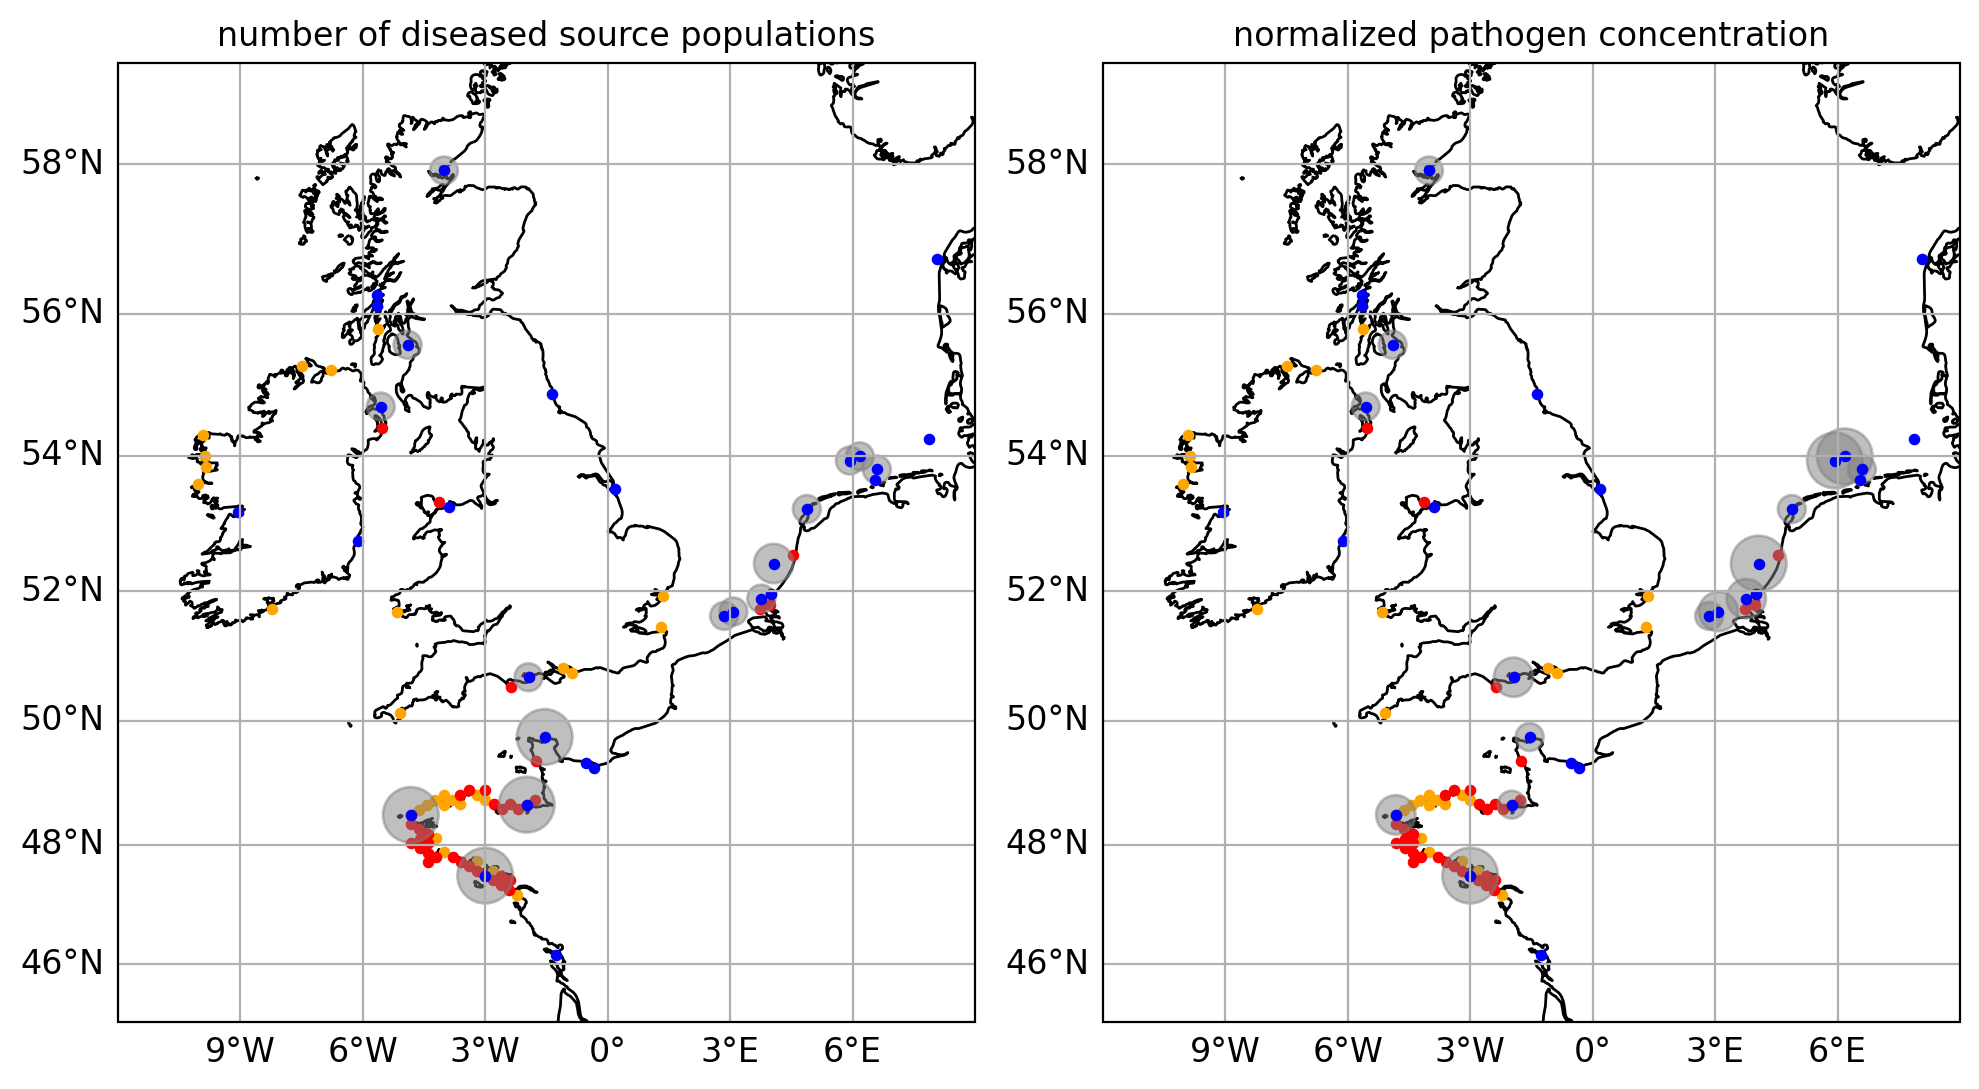

In [29]:
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(200)

fig.patch.set_alpha(0.7)

_dss_to_rst_stats = dss_to_rst_stats.copy()

_dss_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dss_to_rst_stats["rel_pathogen_concentration_category"] *= 100

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_num_dss_sources_category",
    alpha=0.5, color="gray",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", 
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

ax[0].coastlines(zorder=0)

ax[0].set_title("number of diseased source populations")
ax[0].set_extent([-12, 9, 45, 59])
gl1 = ax[0].gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", 
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

ax[1].coastlines(zorder=0)

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 45, 59])
gl2 = ax[1].gridlines(draw_labels=True)
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels;

fig.tight_layout();

fig.savefig("041_rest-sites_risk-analsysis.pdf")

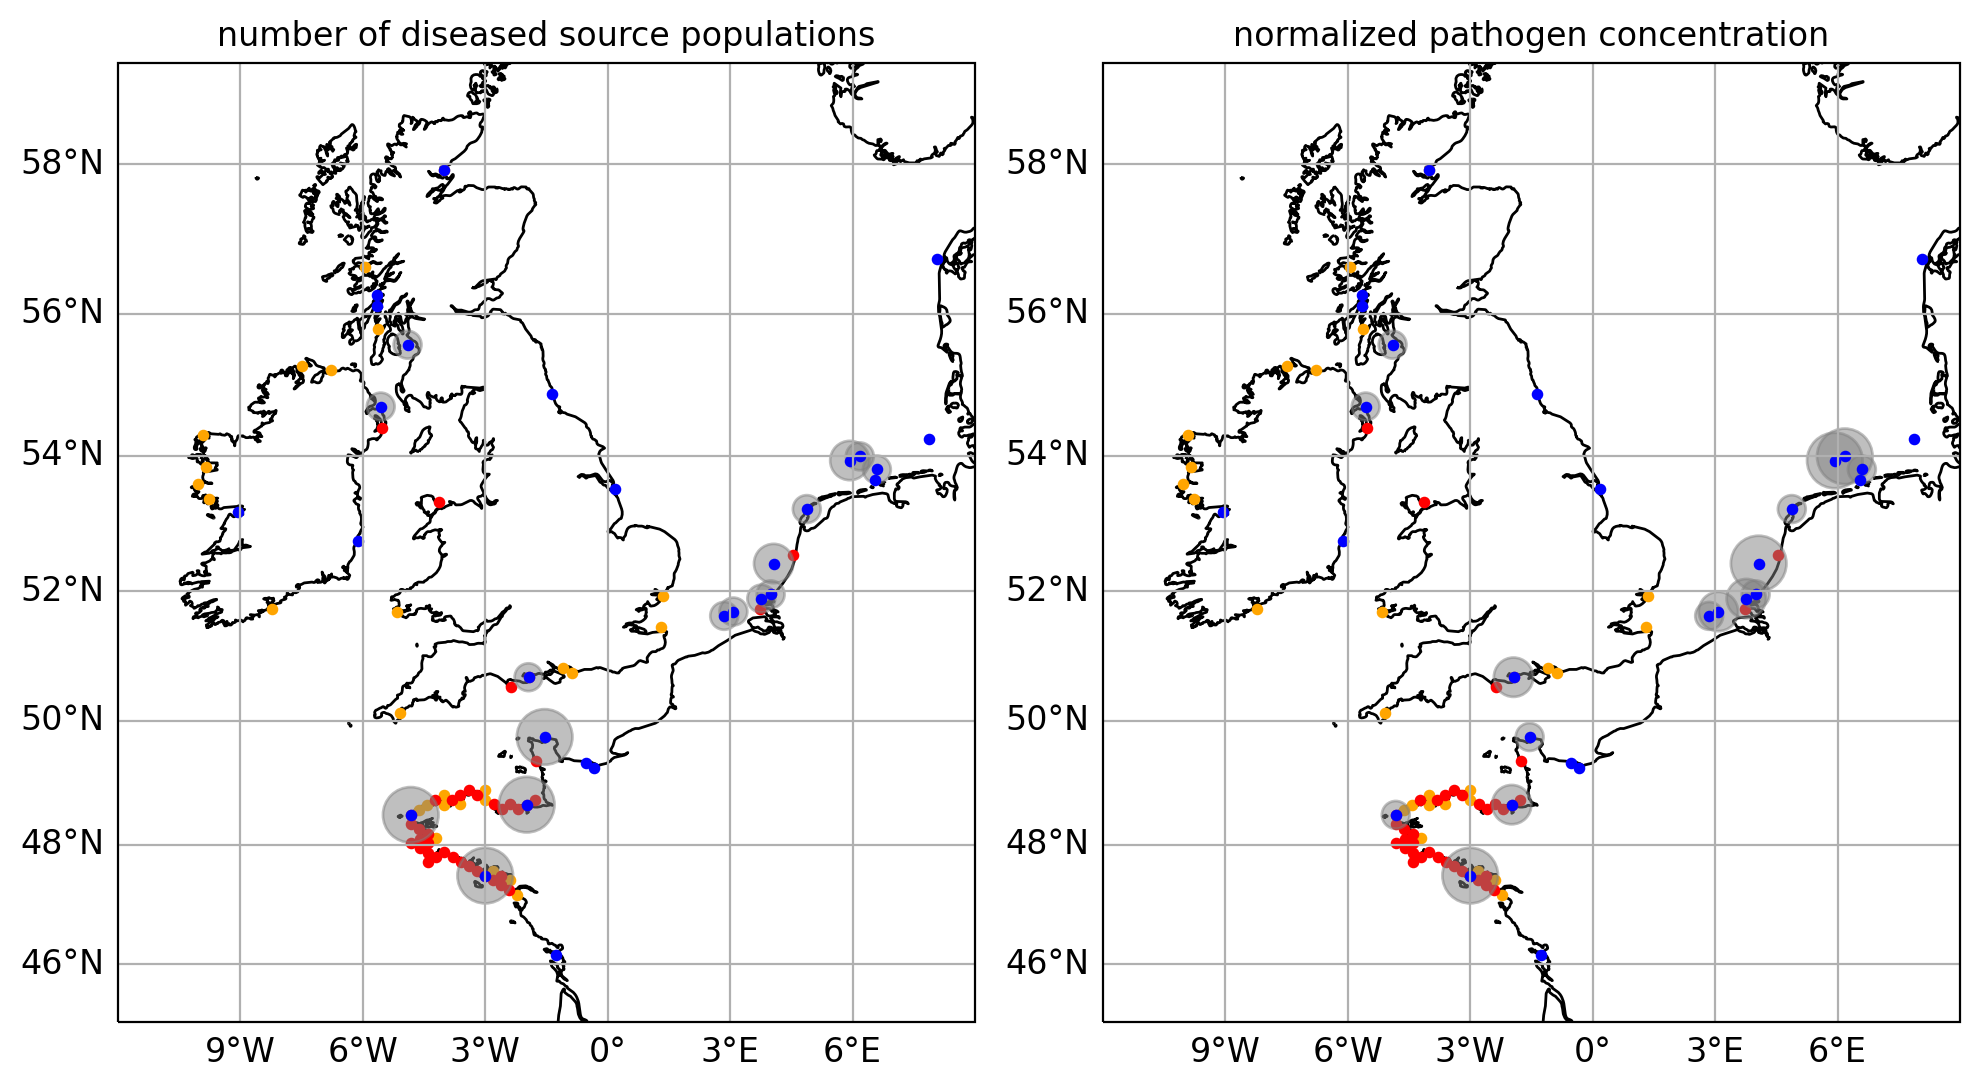

In [69]:
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(200)

fig.patch.set_alpha(0.7)

_dss_to_rst_stats = dss_to_rst_stats.copy()

_dss_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dss_to_rst_stats["rel_pathogen_concentration_category"] *= 100

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_num_dss_sources_category",
    alpha=0.5, color="gray",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", 
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

ax[0].coastlines(zorder=0)

ax[0].set_title("number of diseased source populations")
ax[0].set_extent([-12, 9, 45, 59])
gl1 = ax[0].gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", 
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

ax[1].coastlines(zorder=0)

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 45, 59])
gl2 = ax[1].gridlines(draw_labels=True)
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels;

fig.tight_layout();

fig.savefig("041_rest-sites_risk-analsysis.pdf")

### Add ocean current vectors to plot

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np

import xarray as xr
import numpy as np
#import cmocean
from pathlib import Path
from matplotlib import pyplot as plt

In [23]:
#parameters

current_data_path = (
    "/gxfs_work/geomar/smomw529/2022_north-sea_oysters/"
    "data/ocean/MetO-NWS-PHY-hi-CUR/"
)

In [24]:
data_files = sorted(Path(current_data_path).glob("2021/0[5,6,7,8,9]/*.nc"))
print(f"found {len(data_files)} data files")

found 153 data files


In [25]:
%%time

dataset = xr.open_mfdataset(data_files, chunks={"depth": 1, "time": 24})
dataset

CPU times: user 1.15 s, sys: 471 ms, total: 1.62 s
Wall time: 34.3 s


<xarray.Dataset>
Dimensions:  (time: 3672, lat: 1240, lon: 958, depth: 33)
Coordinates:
  * time     (time) datetime64[ns] 2021-05-01T01:00:00 ... 2021-10-01
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float32 dask.array<chunksize=(24, 1, 1240, 958), meta=np.ndarray>
    vo       (time, depth, lat, lon) float32 dask.array<chunksize=(24, 1, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [26]:
#select relevant months may-sept for one example year 2021 to later calculate and plot the average
subset = dataset.isel(depth=4).sel(time=dataset['time'].dt.strftime('%Y-%m').isin(['2021-05', '2021-06', '2021-07', '2021-08', '2021-09']))
#subset = dataset.isel(depth=4).sel(time=dataset['time'].dt.strftime('%Y-%m').isin(['2021-05']))
subset

<xarray.Dataset>
Dimensions:  (time: 3671, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 2021-05-01T01:00:00 ... 2021-09-30T23:00:00
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
    depth    float32 15.0
Data variables:
    uo       (time, lat, lon) float32 dask.array<chunksize=(24, 1240, 958), meta=np.ndarray>
    vo       (time, lat, lon) float32 dask.array<chunksize=(24, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [27]:
subset_day = dataset.isel(depth=4).sel(time='2021-07-01', method = 'nearest')
subset_day

<xarray.Dataset>
Dimensions:  (lat: 1240, lon: 958)
Coordinates:
    time     datetime64[ns] 2021-07-01
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
    depth    float32 15.0
Data variables:
    uo       (lat, lon) float32 dask.array<chunksize=(1240, 958), meta=np.ndarray>
    vo       (lat, lon) float32 dask.array<chunksize=(1240, 958), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [28]:
subset_month = dataset.isel(depth=4).sel(time='2021-07')
subset_month

<xarray.Dataset>
Dimensions:  (time: 744, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 2021-07-01 ... 2021-07-31T23:00:00
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
    depth    float32 15.0
Data variables:
    uo       (time, lat, lon) float32 dask.array<chunksize=(1, 1240, 958), meta=np.ndarray>
    vo       (time, lat, lon) float32 dask.array<chunksize=(1, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [29]:
intensity = np.sqrt(u**2 + v**2)

NameError: name 'u' is not defined

In [ ]:
# 01.07.2021 
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

ax[1].coastlines(zorder=0)
# ax[1].add_feature(cartopy.feature.LAND)
# ax[1].add_feature(cartopy.feature.BORDERS)
ax[0].coastlines(zorder=0)
# ax[0].add_feature(cartopy.feature.LAND)
# ax[0].add_feature(cartopy.feature.BORDERS)

ax[0].set_title("number of diseased source populations")
ax[0].set_extent([-12, 9, 46, 60])
gl0 = ax[0].gridlines(draw_labels=True, zorder=0)
gl0.top_labels=False   # suppress top labels
gl0.right_labels=False # suppress right labels;

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 46, 60])
gl1 = ax[1].gridlines(draw_labels=True, zorder=0);
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;


#add current velocity and direction vectors

u = subset_day.uo.squeeze()
v = subset_day.vo.squeeze()

# Adjust the length and width of the arrows based on intensity
#scale_factor = 0.1  # Adjust this factor to control the arrow size
#u_scaled = u * scale_factor
#v_scaled = v * scale_factor

lon, lat = np.meshgrid(subset.lon.values, subset.lat.values)

# Define a slice to skip drawing some of the quiver arrows to reduce clutter
skip = (slice(None, None, 15), slice(None, None, 15))

# Use the quiver function to display current vectors with their direction and intensity
#fig.quiver(lon[skip], lat[skip], u_scaled[skip], v_scaled[skip], color='black', latlon=True, scale=2, width=0.003, headwidth=4)

q1 = ax[0].quiver(lon[skip], lat[skip], u[skip], v[skip], color='black', width=0.003, headwidth=2)
q2 = ax[1].quiver(lon[skip], lat[skip], u[skip], v[skip], color='black', width=0.003, headwidth=2)

_dss_to_rst_stats = dss_to_rst_stats.copy()

_dss_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dss_to_rst_stats["rel_pathogen_concentration_category"] *= 100

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_num_dss_sources_category",
    alpha=0.5, color="gray",
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red", zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

# Add quiver keys to each subplot with a valid labelpos
ax[0].quiverkey(q1, 0.47, 0.3, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')
ax[1].quiverkey(q2, 0.96 , 0.3, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')


#fig.patch.set_alpha(0.7)

fig.tight_layout();

fig.savefig("plots/041_rest-sites_risk-analsysis_velocity_01july2021.pdf")


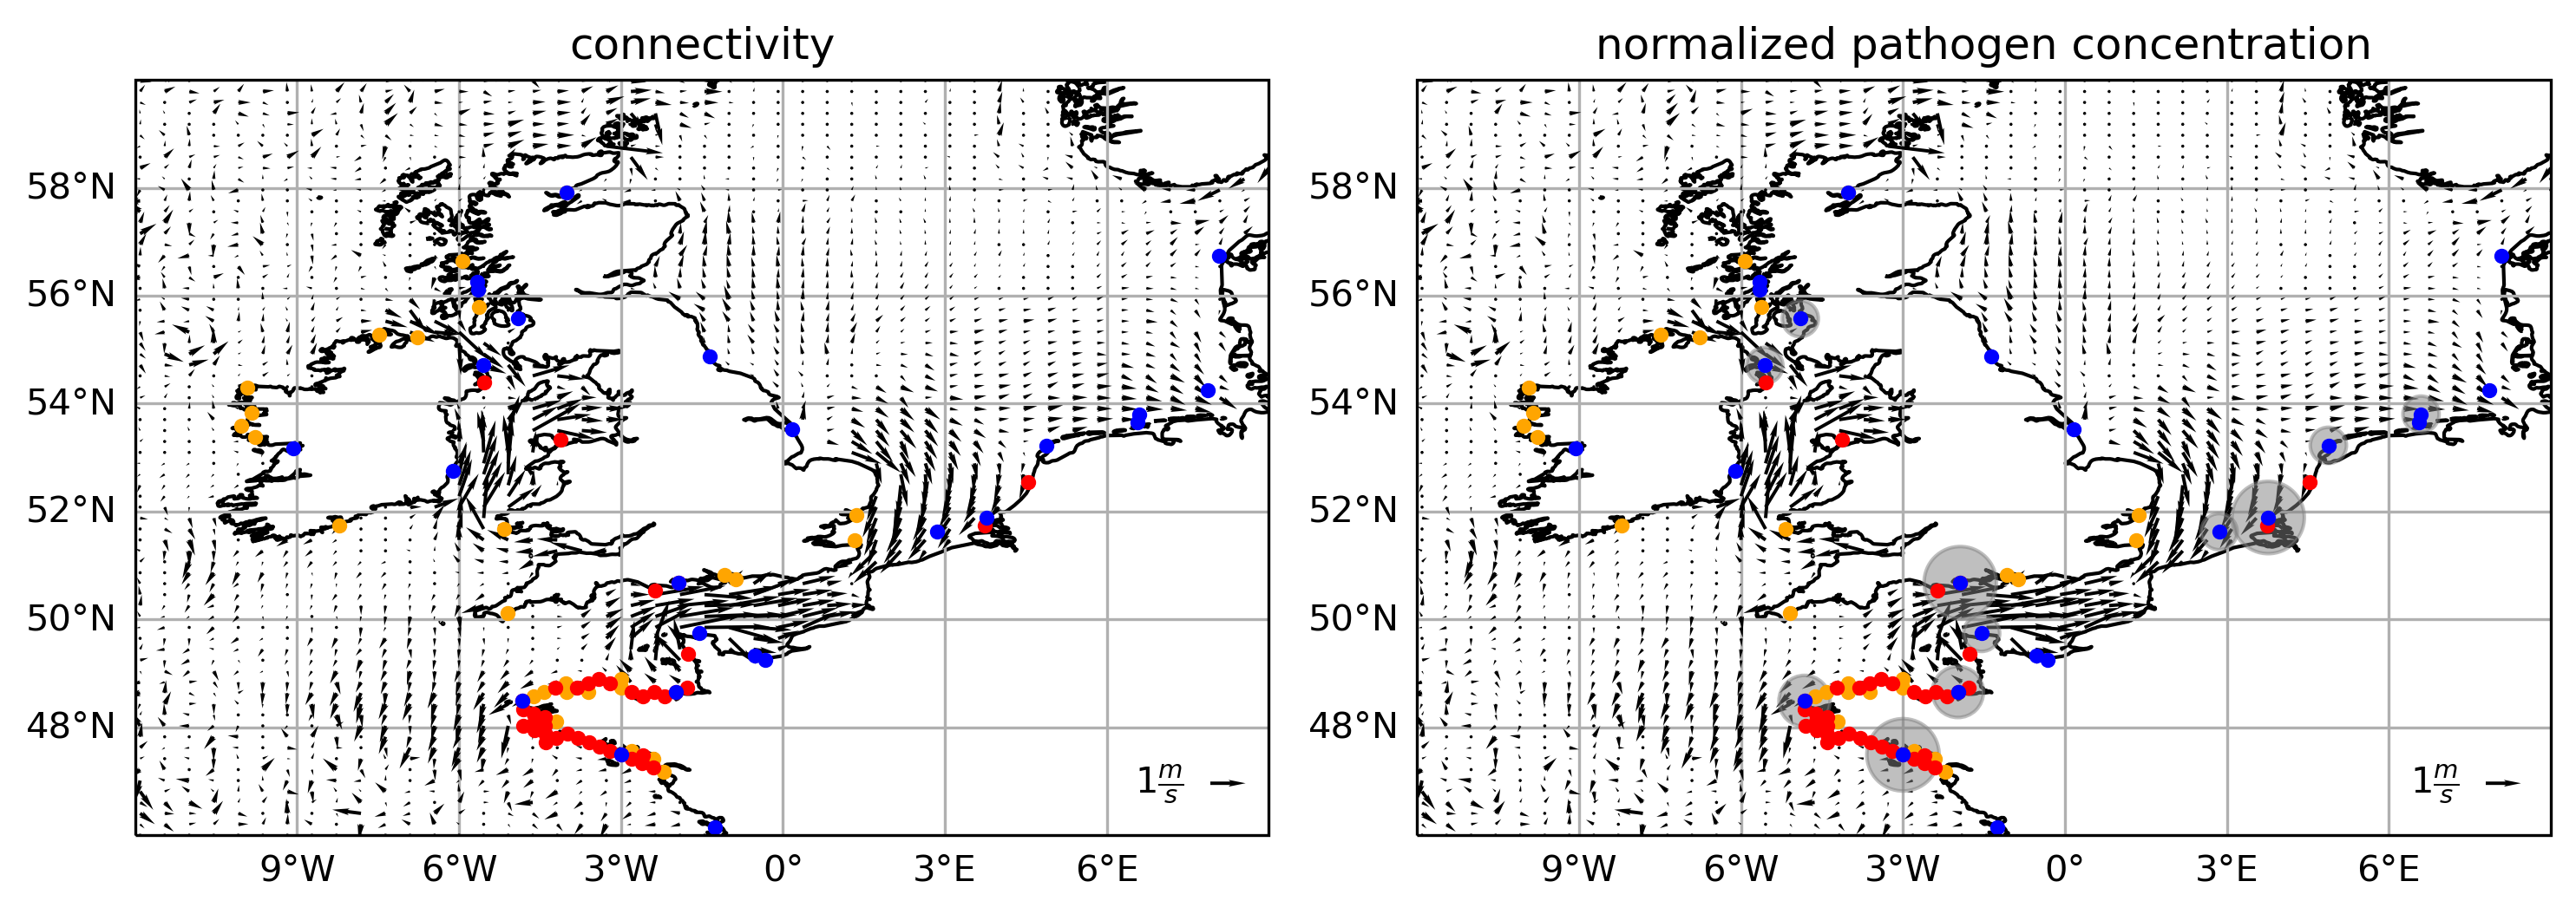

In [25]:
#01.07.2021 version for Arne & Julia

# 01.07.2021 
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(
    1, 2,
    # subplot_kw={"projection": cartopy.crs.Stereographic(
    #     central_longitude=ds_conn.hex_proj__lon_origin,
    #     central_latitude=ds_conn.hex_proj__lat_origin,
    # )},
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

ax[0].coastlines(zorder=0)
ax[1].coastlines(zorder=0)

ax[0].set_title("connectivity")
ax[0].set_extent([-12, 9, 46, 60])
gl0 = ax[0].gridlines(draw_labels=True, zorder=0)
gl0.top_labels=False   # suppress top labels
gl0.right_labels=False # suppress right labels;

ax[1].set_title("normalized pathogen concentration")
ax[1].set_extent([-12, 9, 46, 60])
gl1 = ax[1].gridlines(draw_labels=True, zorder=0);
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

#add current velocity and direction vectors

u = subset_day.uo.squeeze()
v = subset_day.vo.squeeze()

# Adjust the length and width of the arrows based on intensity
#scale_factor = 0.1  # Adjust this factor to control the arrow size
#u_scaled = u * scale_factor
#v_scaled = v * scale_factor

lon, lat = np.meshgrid(subset.lon.values, subset.lat.values)

# Define a slice to skip drawing some of the quiver arrows to reduce clutter
skip = (slice(None, None, 15), slice(None, None, 15))

# Use the quiver function to display current vectors with their direction and intensity
#fig.quiver(lon[skip], lat[skip], u_scaled[skip], v_scaled[skip], color='black', latlon=True, scale=2, width=0.003, headwidth=4)

q1 = ax[0].quiver(lon[skip], lat[skip], u[skip], v[skip], color='black', width=0.003, headwidth=2)
q2 = ax[1].quiver(lon[skip], lat[skip], u[skip], v[skip], color='black', width=0.003, headwidth=2)

_dss_to_rst_stats = dss_to_rst_stats.copy()

_dss_to_rst_stats["rel_num_dss_sources_category"] *= 100
_dss_to_rst_stats["rel_pathogen_concentration_category"] *= 100

_dss_to_rst_stats.plot.scatter(
    x="lon", y="lat", s="rel_pathogen_concentration_category",
    alpha=0.5, color="gray",
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", zorder=1,
    ax=ax[0], transform=cartopy.crs.PlateCarree()
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] == 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="orange",zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

dss_origins_01y.where(dss_origins_01y["obs_per_origin_area"] > 0).plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, color="red", zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree(),
)

known_rst_sites.plot.scatter(
    x="lon_hex0", y="lat_hex0", s=10, 
    color="blue", zorder=1,
    ax=ax[1], transform=cartopy.crs.PlateCarree()
)

# Add quiver keys to each subplot with a valid labelpos
ax[0].quiverkey(q1, 0.47, 0.3, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')
ax[1].quiverkey(q2, 0.96 , 0.3, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')


#fig.patch.set_alpha(0.7)

fig.tight_layout();

fig.savefig("plots/041_rest-sites_risk-analsysis_velocity_01july2021_OHmeeting.pdf")